/tmp/ipykernel_20935/2816952773.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=order, showfliers=False, showmeans=True,


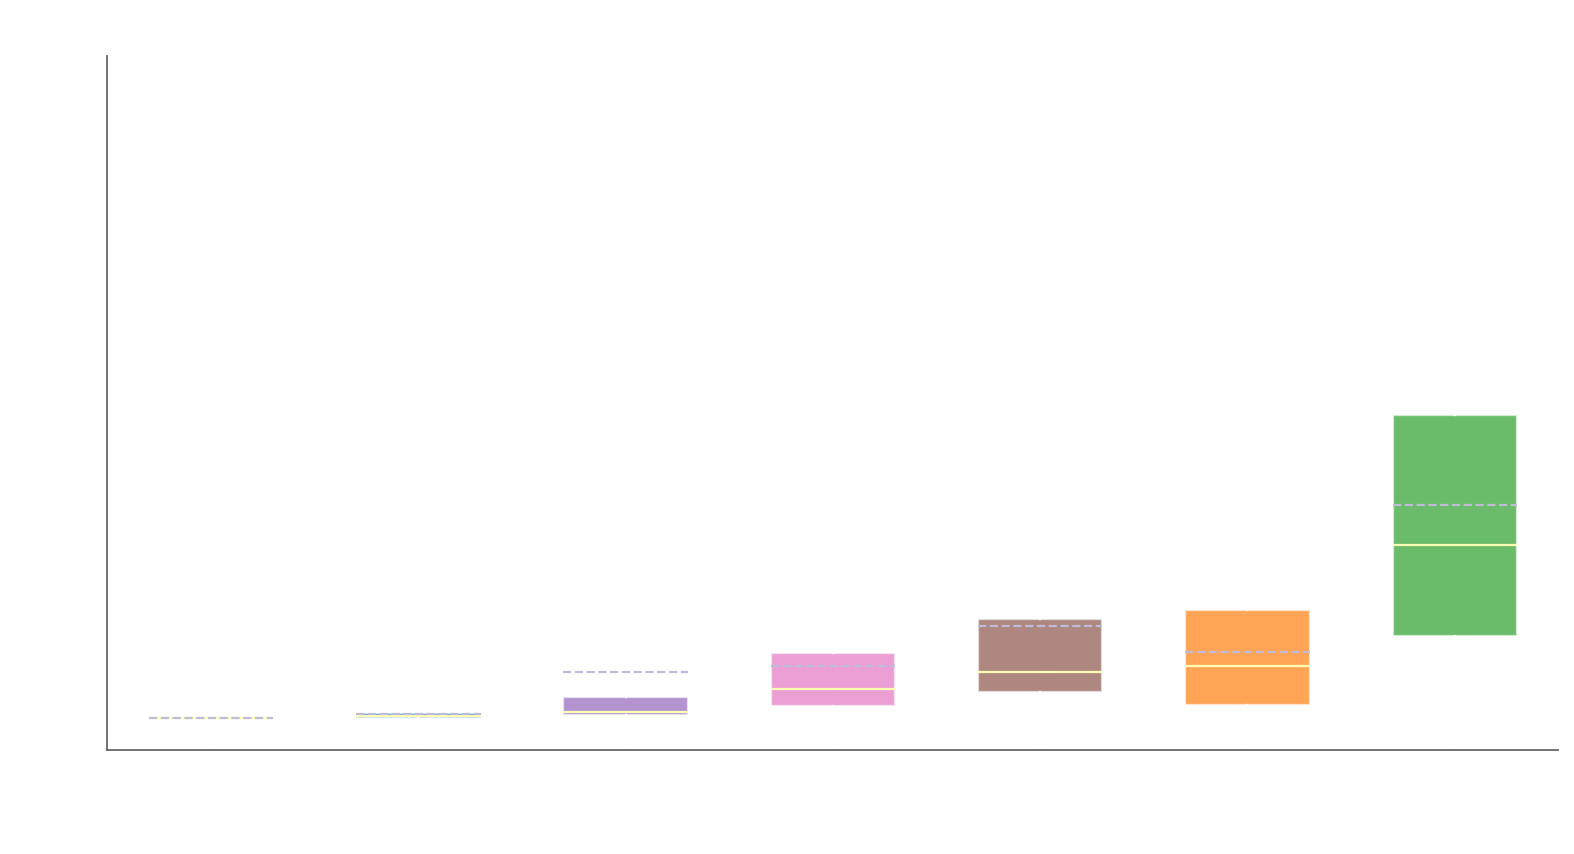

/home/teevik/Documents/Projects/python_motion_planning/.devenv/state/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


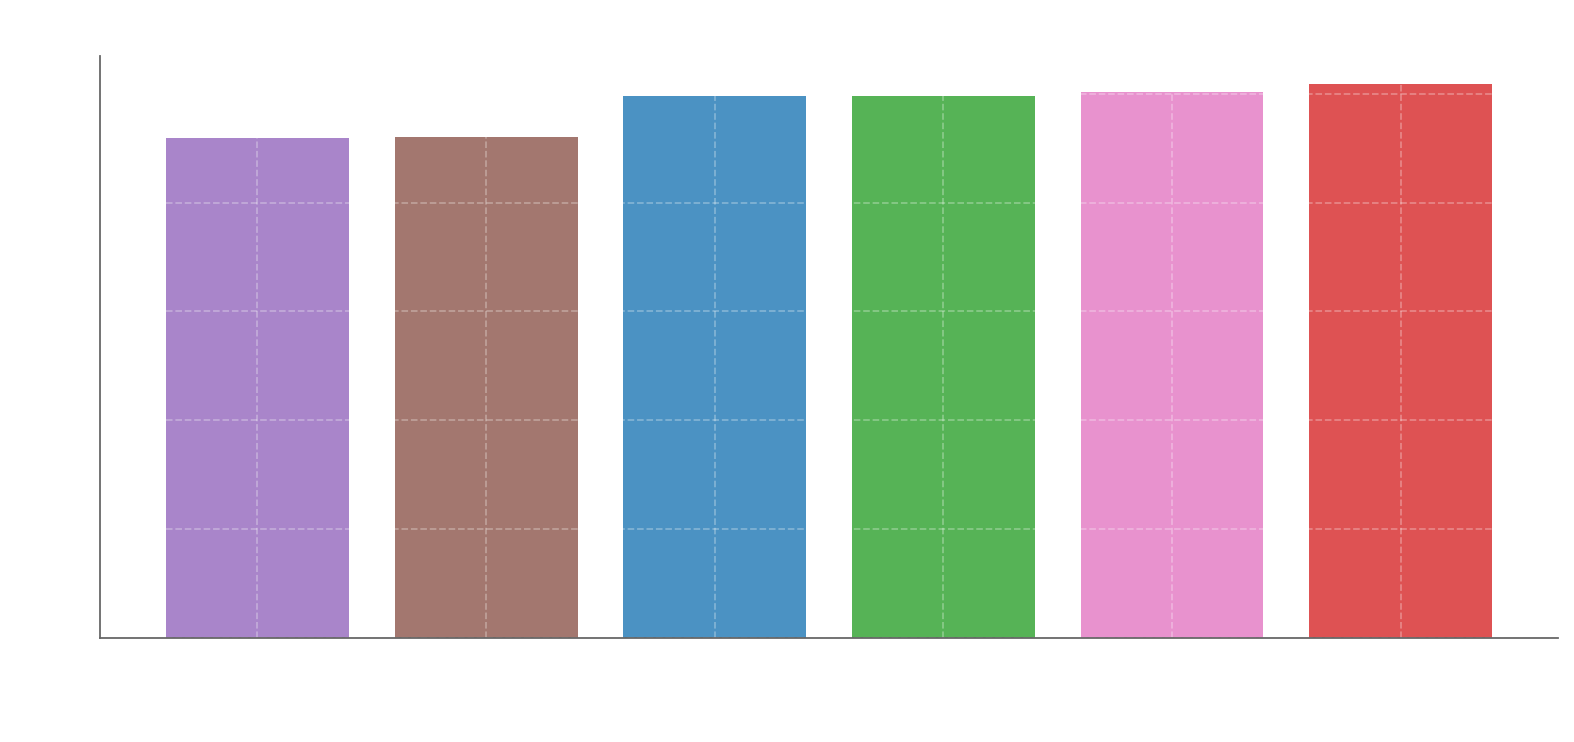

/home/teevik/Documents/Projects/python_motion_planning/.devenv/state/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


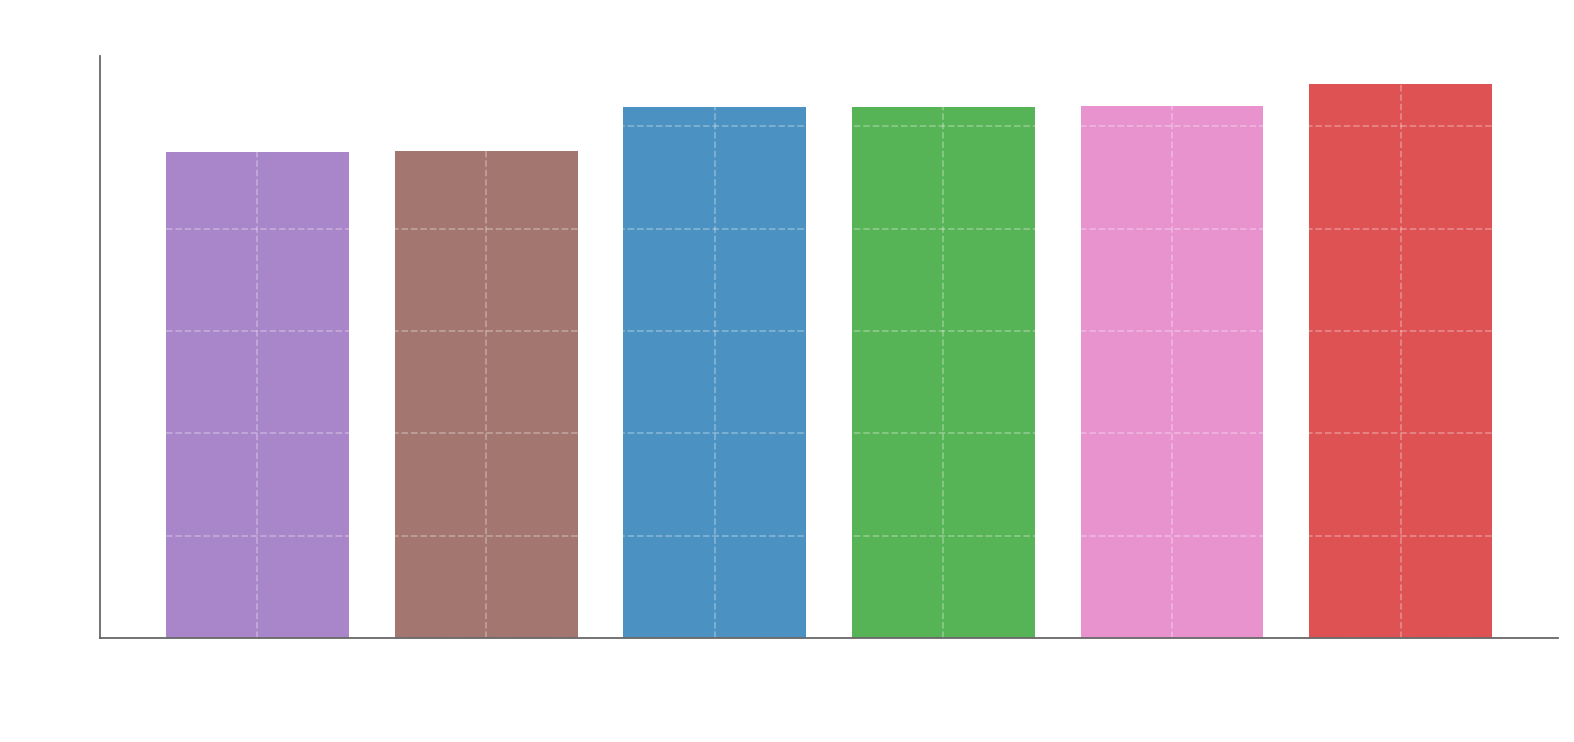

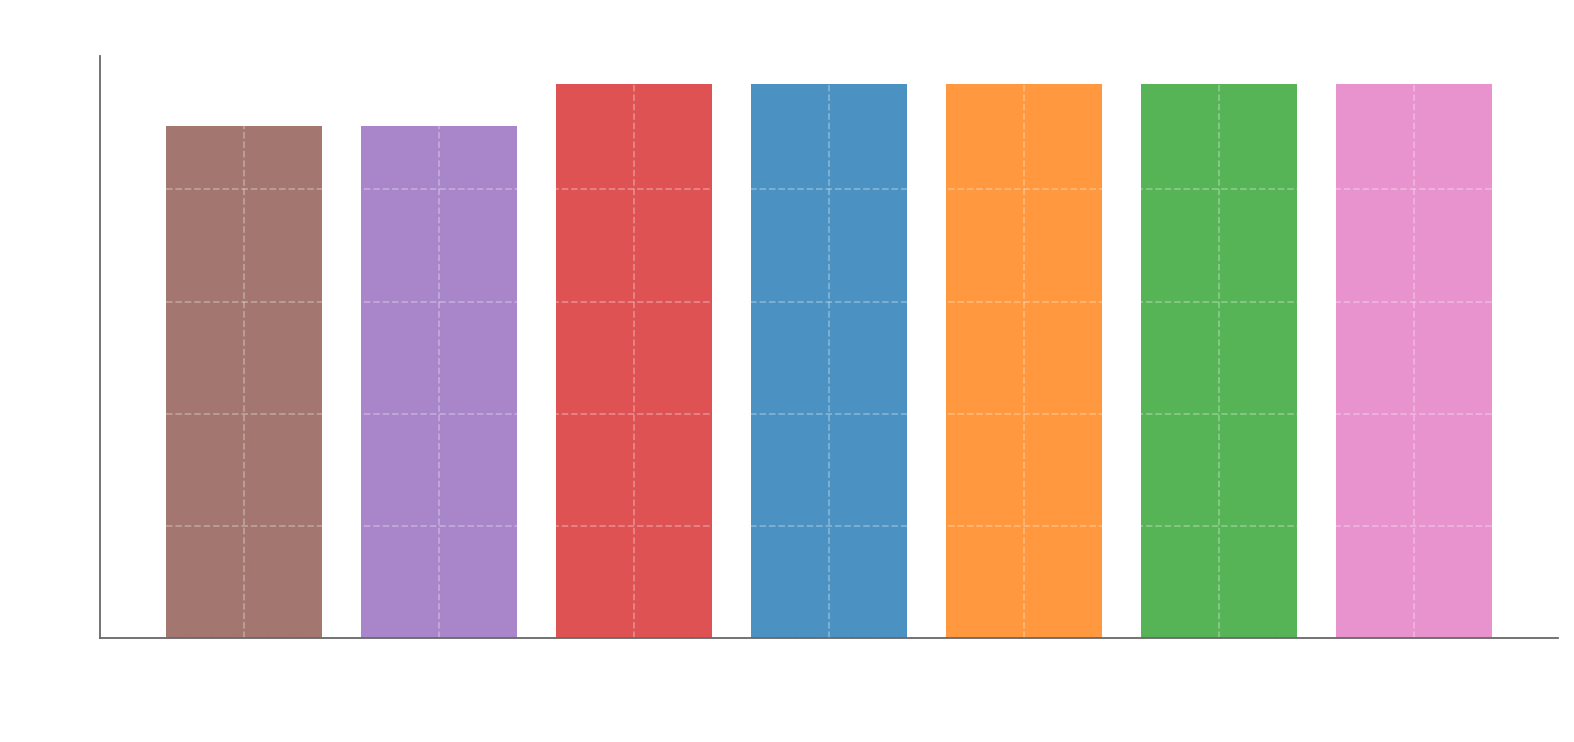

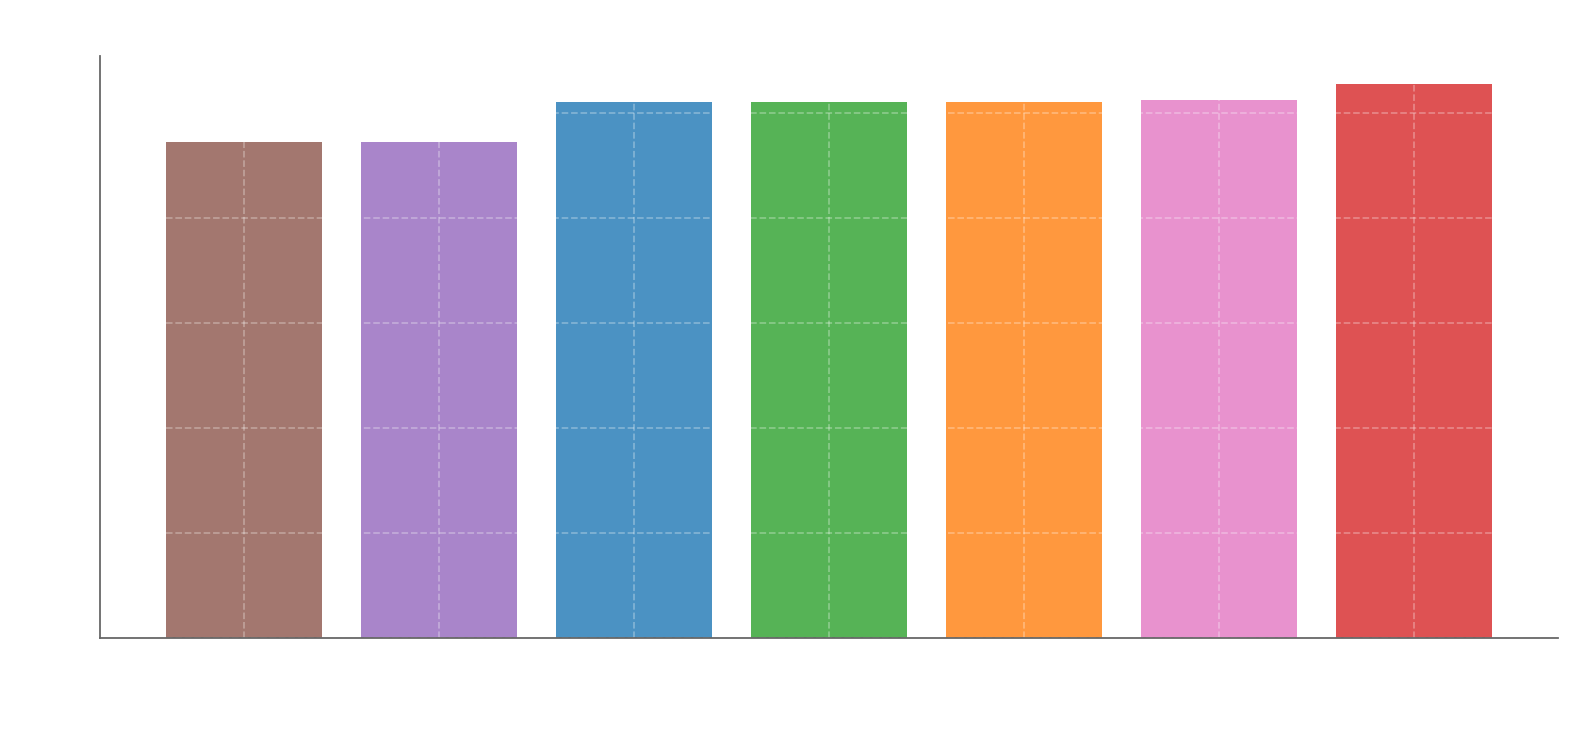

/home/teevik/Documents/Projects/python_motion_planning/.devenv/state/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


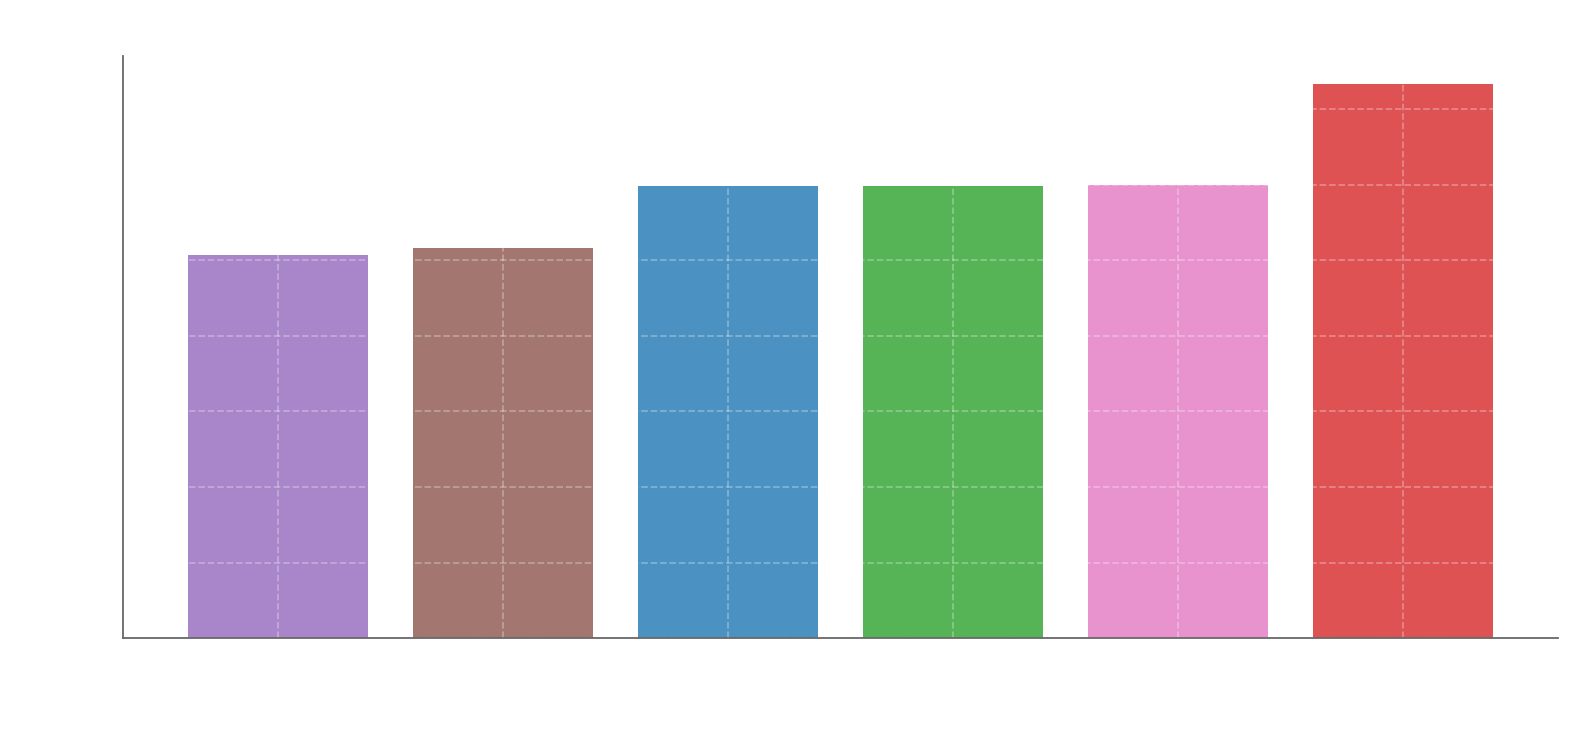

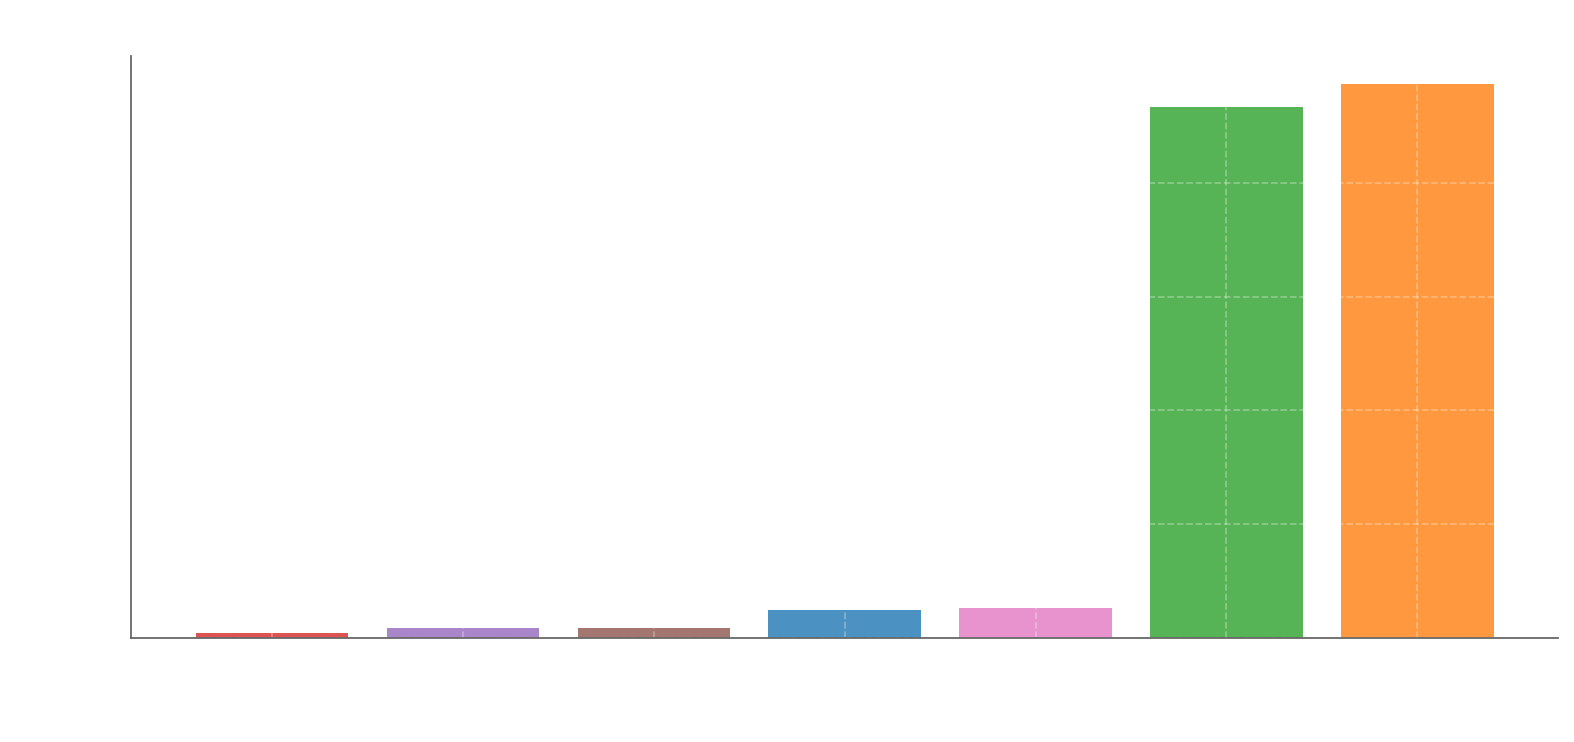

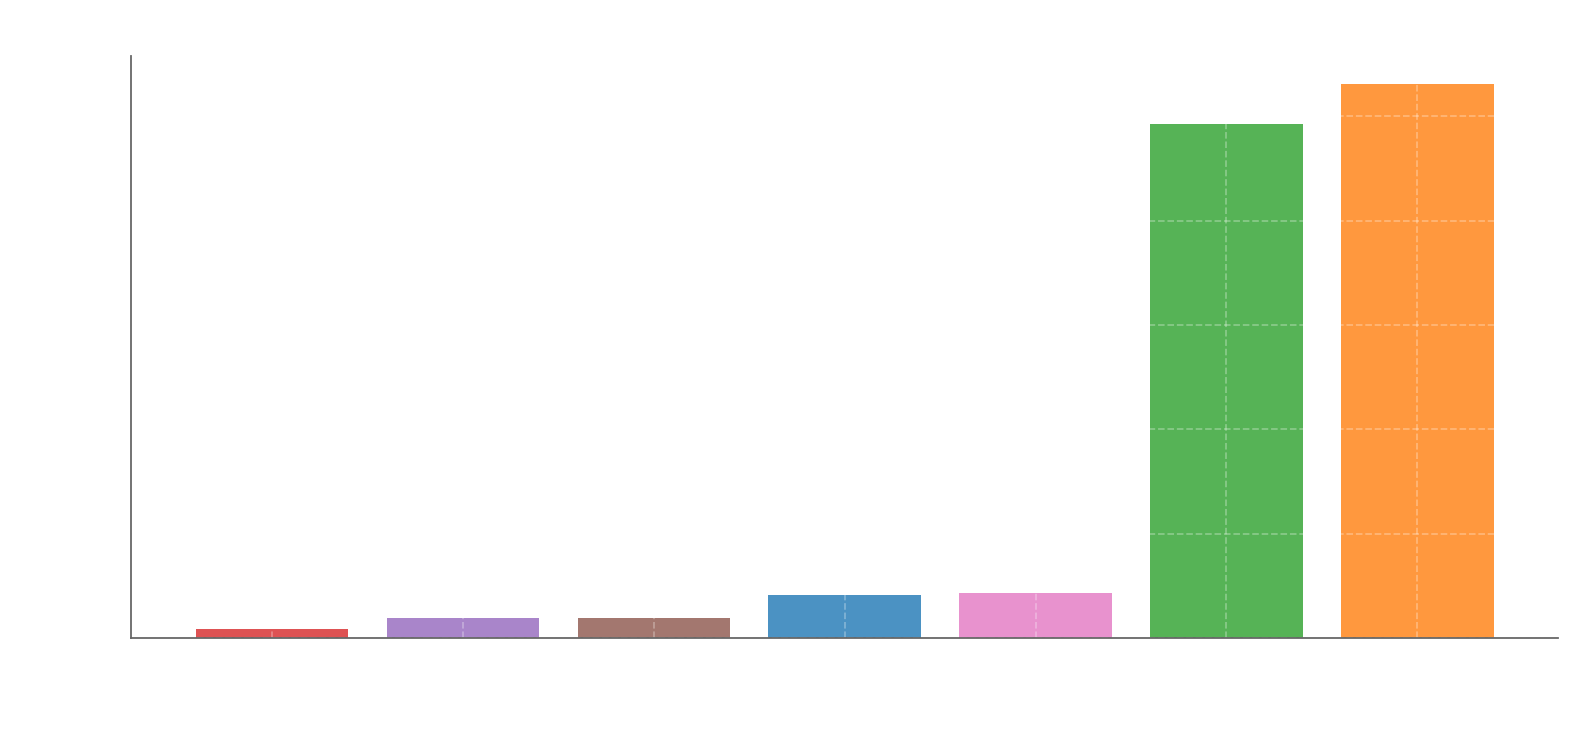

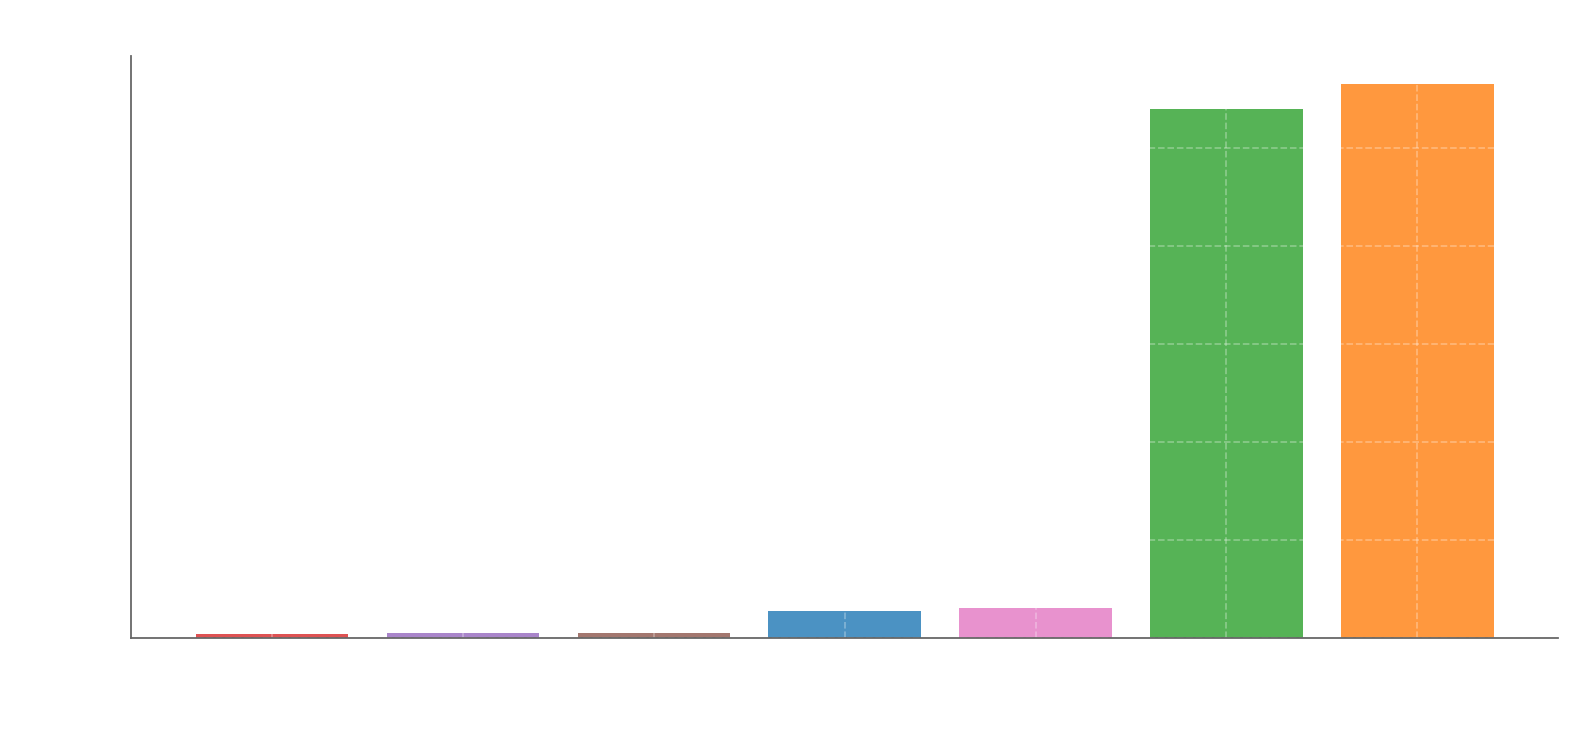

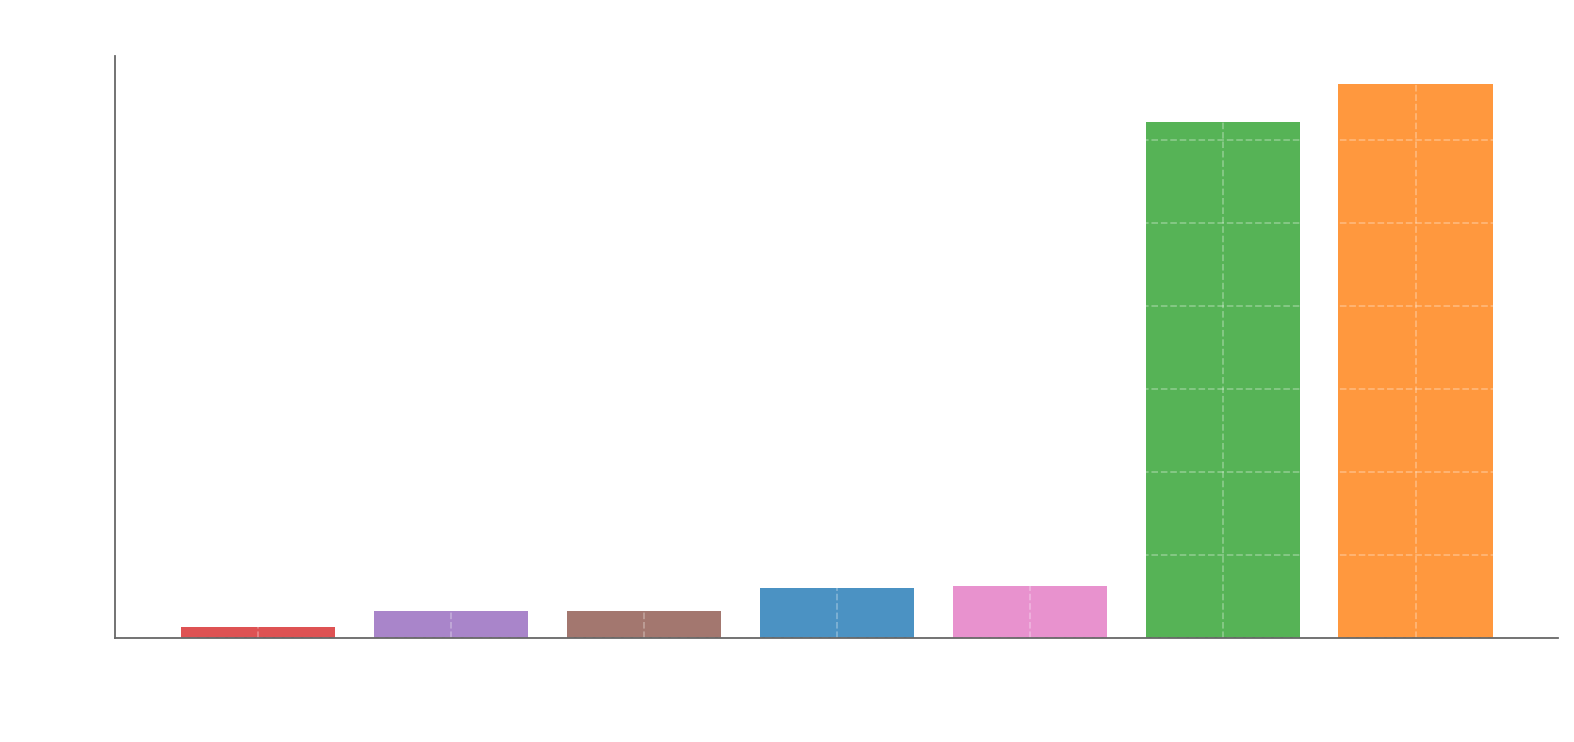

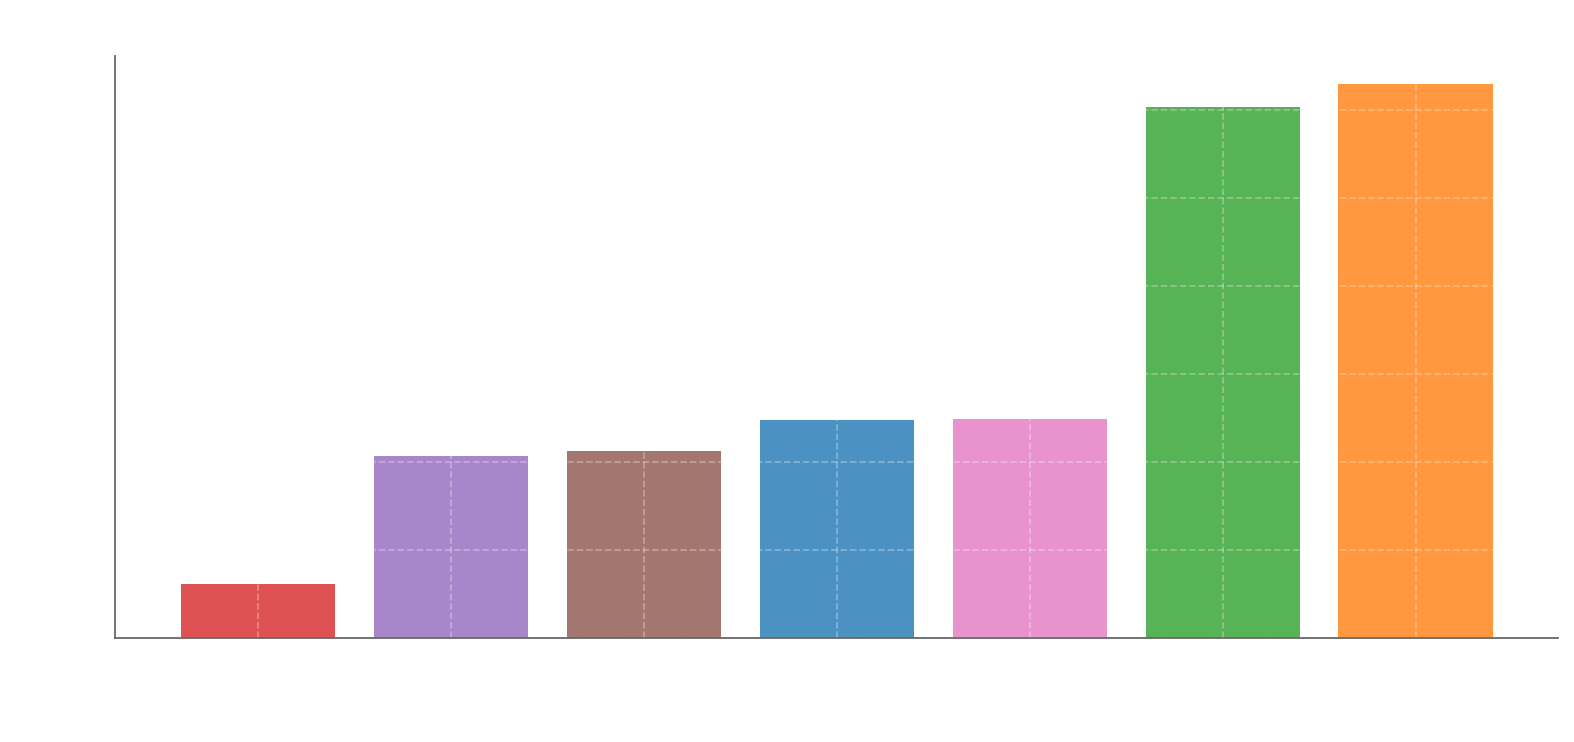

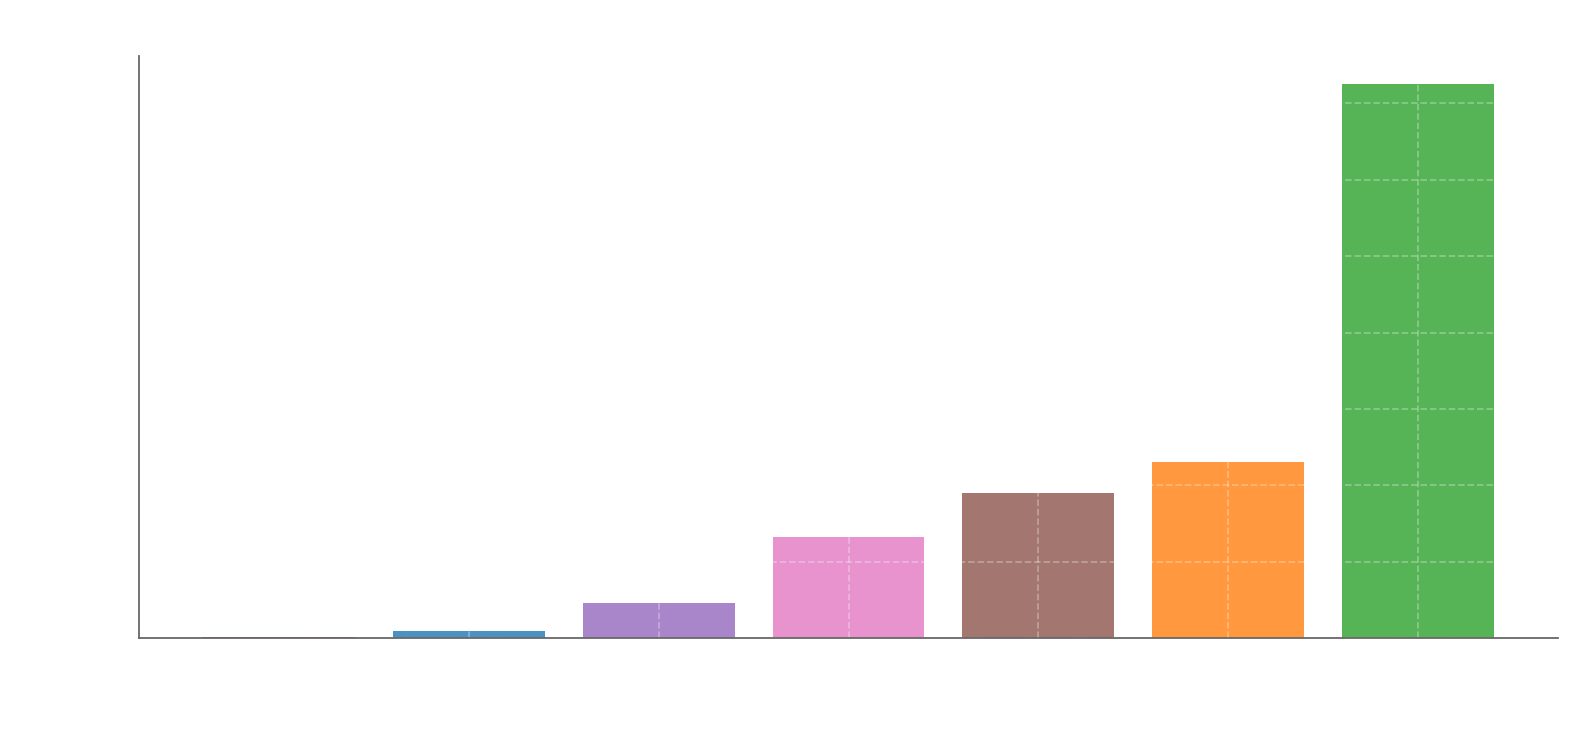

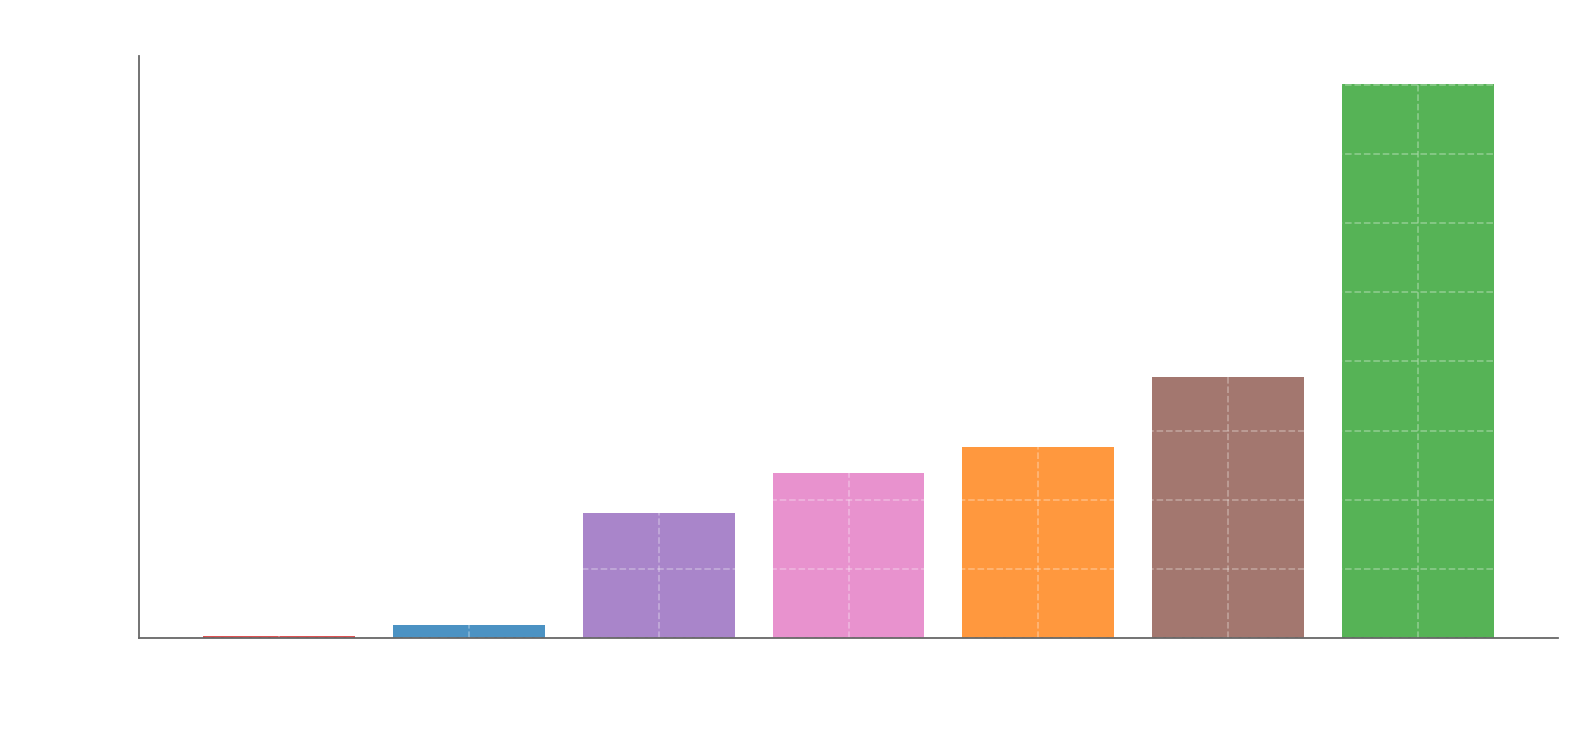

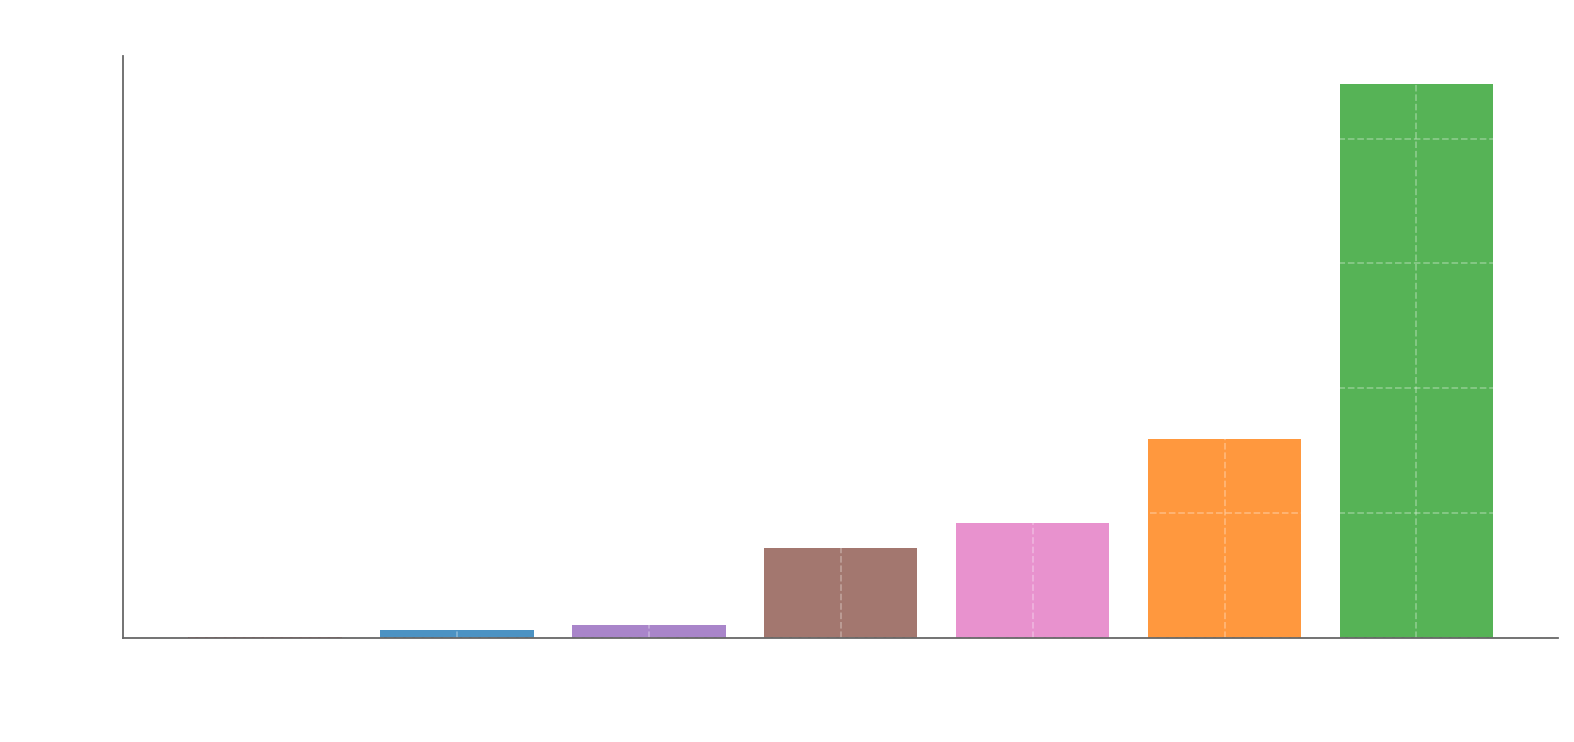

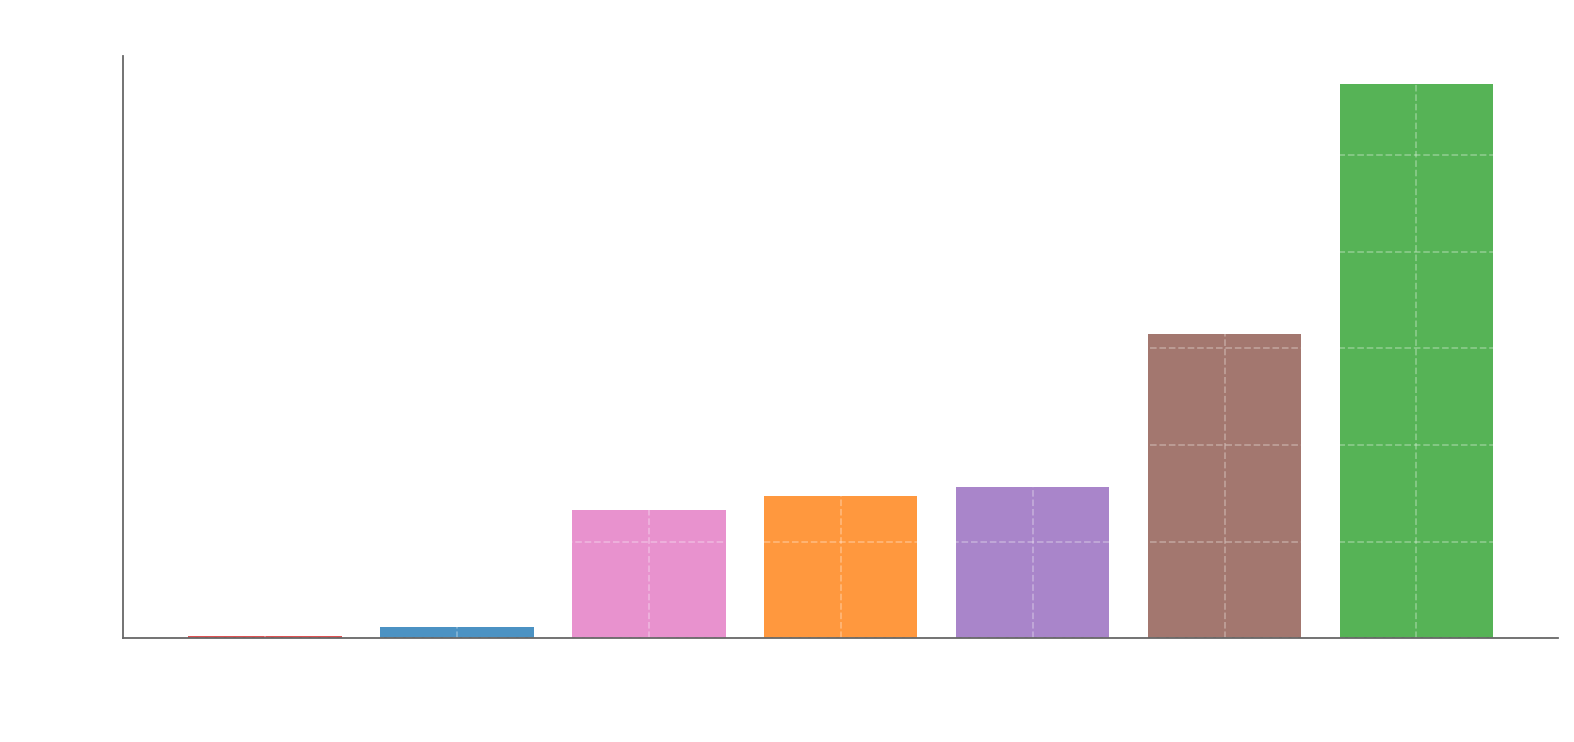

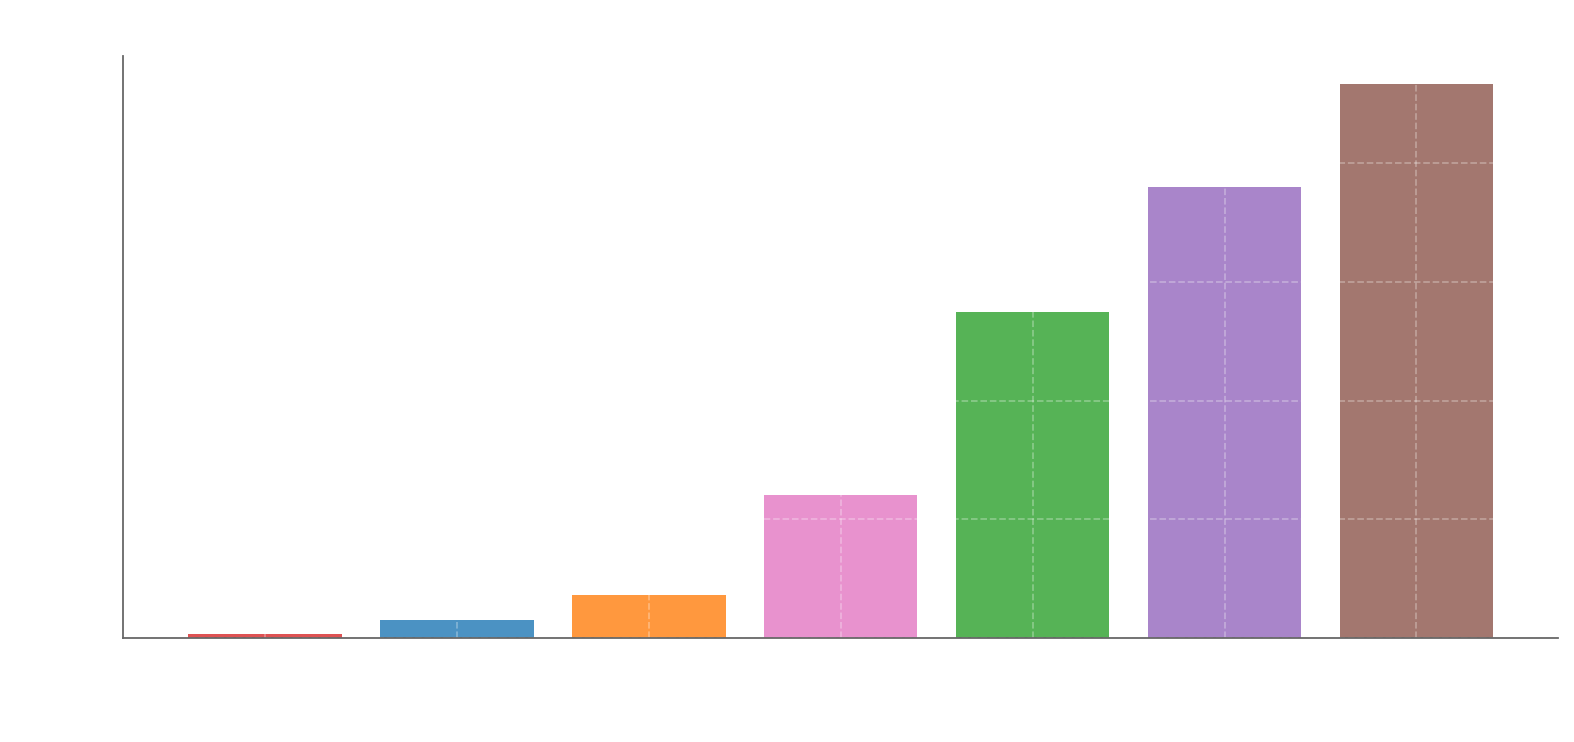

['../output/bar_mean_distance_city.png',
 '../output/bar_mean_distance_door.png',
 '../output/bar_mean_distance_empty.png',
 '../output/bar_mean_distance_floors.png',
 '../output/bar_mean_distance_maze.png',
 '../output/bar_mean_runtime_city.png',
 '../output/bar_mean_runtime_door.png',
 '../output/bar_mean_runtime_empty.png',
 '../output/bar_mean_runtime_floors.png',
 '../output/bar_mean_runtime_maze.png',
 '../output/bar_mean_visited_city.png',
 '../output/bar_mean_visited_door.png',
 '../output/bar_mean_visited_empty.png',
 '../output/bar_mean_visited_floors.png',
 '../output/bar_mean_visited_maze.png',
 '../output/box_runtime_by_algorithm.png',
 '../output/box_runtime_by_algorithm_city.png']

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

csv_path = Path("../3d_pathfinding_results.csv")
out_dir = Path("../output")
out_dir.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(csv_path).rename(columns={
    "Runtime (s)": "runtime_s",
    "Distance": "distance",
    "Visited Nodes": "visited",
})
for col in ["runtime_s","distance","visited"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["runtime_s","distance","visited","Algorithm","Scenario"])

# Set dark mode style
plt.style.use('dark_background')
plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 200,
    "figure.figsize": (9,6),
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.facecolor": "none",
    "axes.facecolor": "none",
    "text.color": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "#ffffff",
    "axes.edgecolor": "#666666",
})

# Create a color map for algorithms
algorithms = df["Algorithm"].unique().tolist()
cmap = plt.get_cmap("tab10")
colors = {alg: cmap(i % 10) for i, alg in enumerate(algorithms)}

def savefig(path_no_ext: Path):
    plt.tight_layout()
    plt.savefig(path_no_ext.with_suffix(".png"), bbox_inches="tight", facecolor="none", transparent=True)
    plt.savefig(path_no_ext.with_suffix(".svg"), bbox_inches="tight", facecolor="none", transparent=True)
    plt.show()


# ---------- Boxplots ----------
def boxplot_metric(metric, ylabel, title, filename):
    order = df.groupby("Algorithm")[metric].median().sort_values().index.tolist()
    data = [df[df["Algorithm"]==alg][metric].dropna().values for alg in order]
    plt.figure(figsize=(10,5.5))
    bp = plt.boxplot(data, labels=order, showfliers=False, showmeans=True,
                     meanline=True, widths=0.6, patch_artist=True)
    for patch, alg in zip(bp['boxes'], order):
        patch.set_facecolor(colors[alg])
        patch.set_alpha(0.7)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=15, ha="right")
    savefig(out_dir / filename)

# boxplot_metric("distance", "Path length (squares)", "Distance by Algorithm", "box_distance_by_algorithm")
# boxplot_metric("visited", "Visited nodes", "Visited Nodes by Algorithm", "box_visited_by_algorithm")
boxplot_metric("runtime_s", "Runtime (s)", "Runtime by Algorithm", "box_runtime_by_algorithm")

# ---------- Per-scenario bar charts ----------
def autolabel(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:.2f}", (p.get_x()+p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=9, xytext=(0,3),
                    textcoords='offset points', color='white')

def per_scenario_bars(metric, ylabel, title_prefix, filename_prefix):
    means = (df.groupby(["Scenario","Algorithm"])[metric]
               .mean()
               .reset_index())
    for scen, sub in means.groupby("Scenario"):
        order = sub.sort_values(metric)["Algorithm"].tolist()
        vals = sub.set_index("Algorithm").loc[order][metric].values
        fig, ax = plt.subplots(figsize=(10,4.8))
        bars = ax.bar(order, vals, color=[colors[alg] for alg in order], alpha=0.8)
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title_prefix} ({scen.capitalize()} Scenario)")
        ax.tick_params(axis='x', labelrotation=15)
        autolabel(ax)
        savefig(out_dir / f"{filename_prefix}_{scen}")

per_scenario_bars("distance", "Mean path length (squares)", "Mean Distance by Algorithm", "bar_mean_distance")
per_scenario_bars("visited", "Mean visited nodes", "Mean Visited Nodes by Algorithm", "bar_mean_visited")
per_scenario_bars("runtime_s", "Mean runtime (s)", "Mean Runtime by Algorithm", "bar_mean_runtime")

sorted([str(p) for p in out_dir.glob("*.png")])

## Additional Plots

The following plots are added for deeper analysis:

- Boxplots for path length (distance) and visited nodes by algorithm
- Scatter plots: runtime vs. distance, visited nodes vs. distance (per algorithm)
- Distribution plots (histograms) for runtime, distance, and visited nodes
- Grouped bar charts comparing all algorithms across all scenarios
- Success rate plot (if applicable)
- Pairplot/matrix plot for metric relationships
- Heatmap of mean metrics (algorithms vs. scenarios)

/tmp/ipykernel_20935/2816952773.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=order, showfliers=False, showmeans=True,


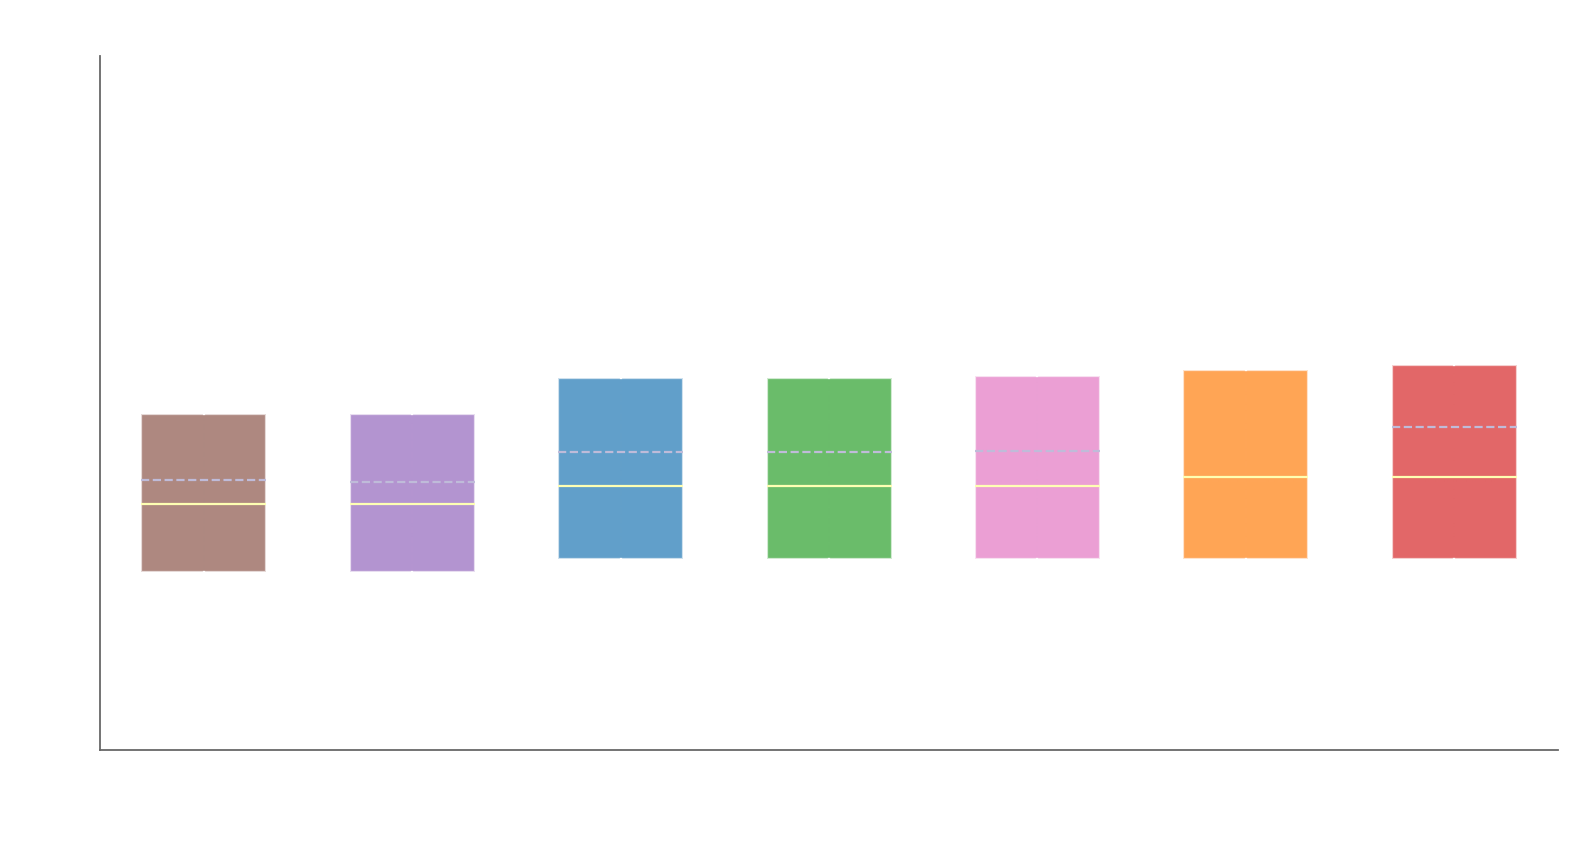

/tmp/ipykernel_20935/2816952773.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=order, showfliers=False, showmeans=True,


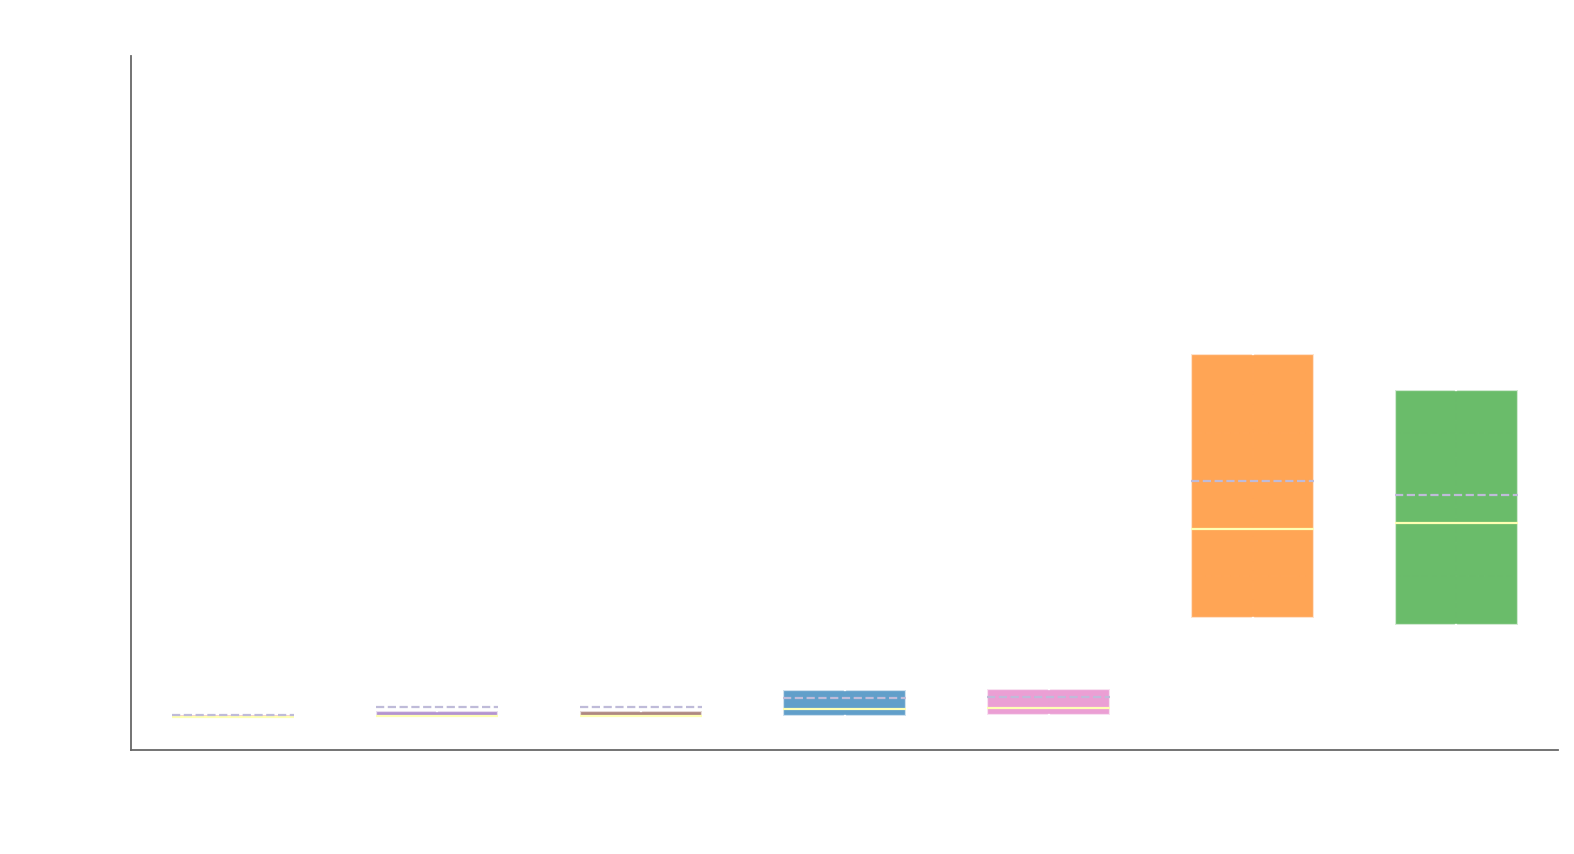

In [2]:
# Boxplot: Path length (distance) by algorithm
boxplot_metric("distance", "Path length (squares)", "Distance by Algorithm", "box_distance_by_algorithm")

# Boxplot: Visited nodes by algorithm
boxplot_metric("visited", "Visited nodes", "Visited Nodes by Algorithm", "box_visited_by_algorithm")

/tmp/ipykernel_20935/3450582285.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=order, showfliers=False, showmeans=True,


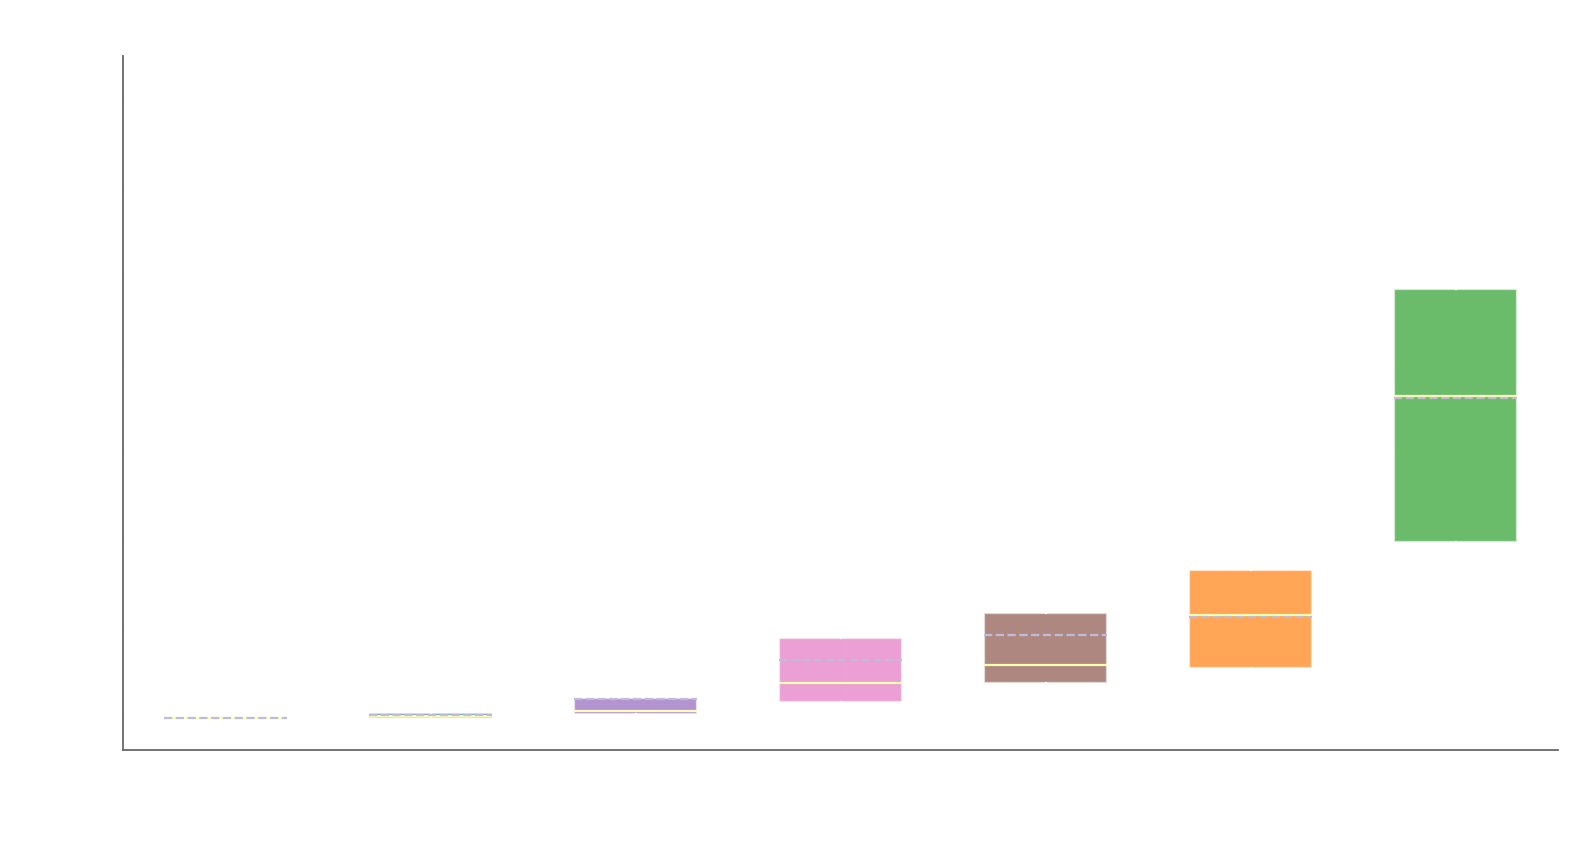

In [3]:
# Boxplot: Runtime by algorithm for 'city' scenario only
df_city = df[df["Scenario"] == "city"]
def boxplot_metric_city(metric, ylabel, title, filename):
    order = df_city.groupby("Algorithm")[metric].median().sort_values().index.tolist()
    data = [df_city[df_city["Algorithm"]==alg][metric].dropna().values for alg in order]
    plt.figure(figsize=(10,5.5))
    bp = plt.boxplot(data, labels=order, showfliers=False, showmeans=True,
                     meanline=True, widths=0.6, patch_artist=True)
    for patch, alg in zip(bp['boxes'], order):
        patch.set_facecolor(colors[alg])
        patch.set_alpha(0.7)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=15, ha="right")
    savefig(out_dir / filename)

boxplot_metric_city("runtime_s", "Runtime (s)", "Runtime by Algorithm (City Scenario)", "box_runtime_by_algorithm_city")

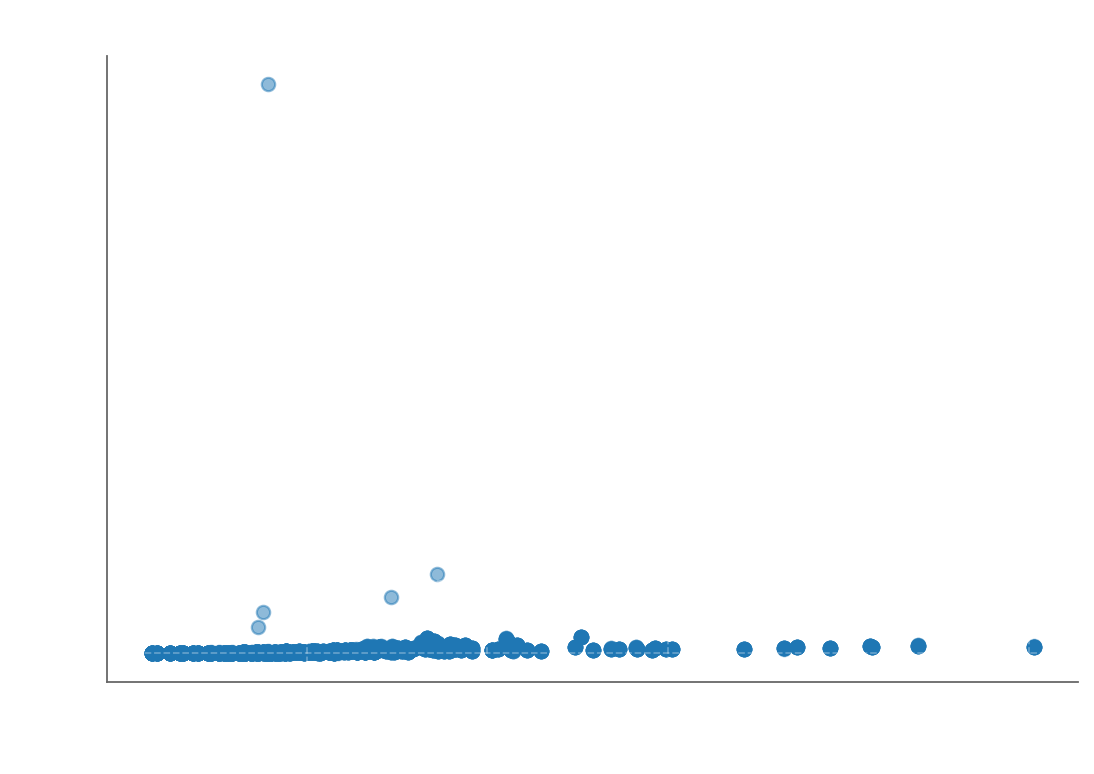

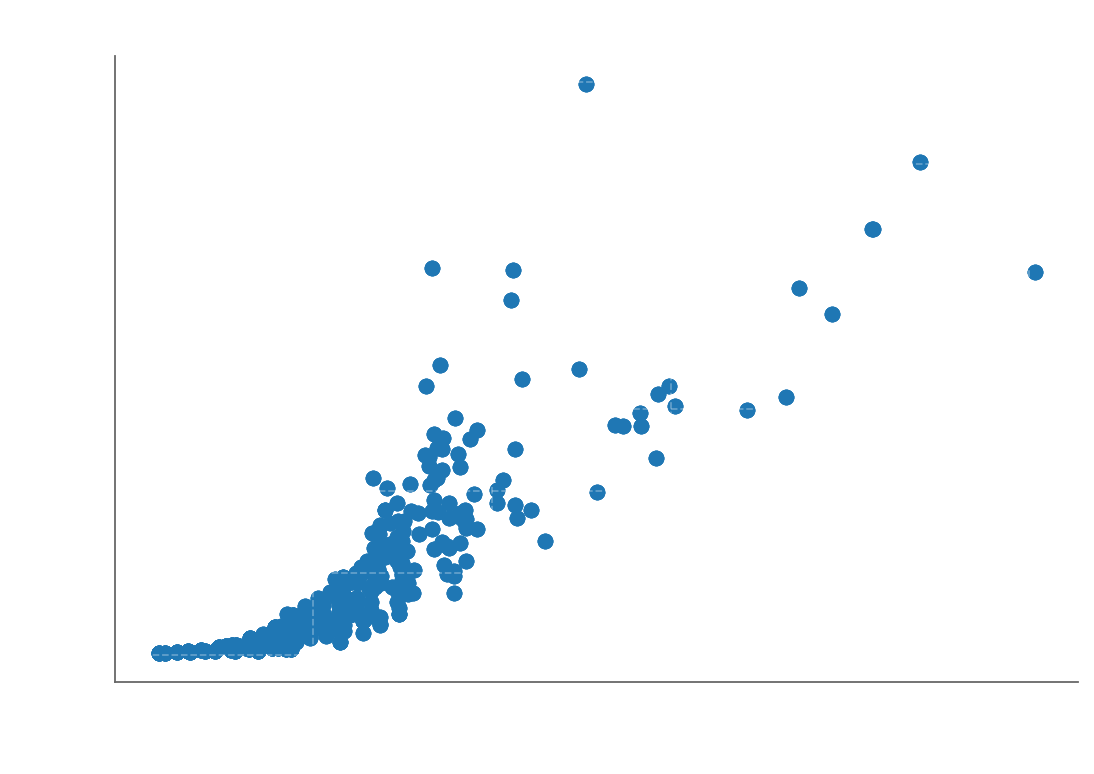

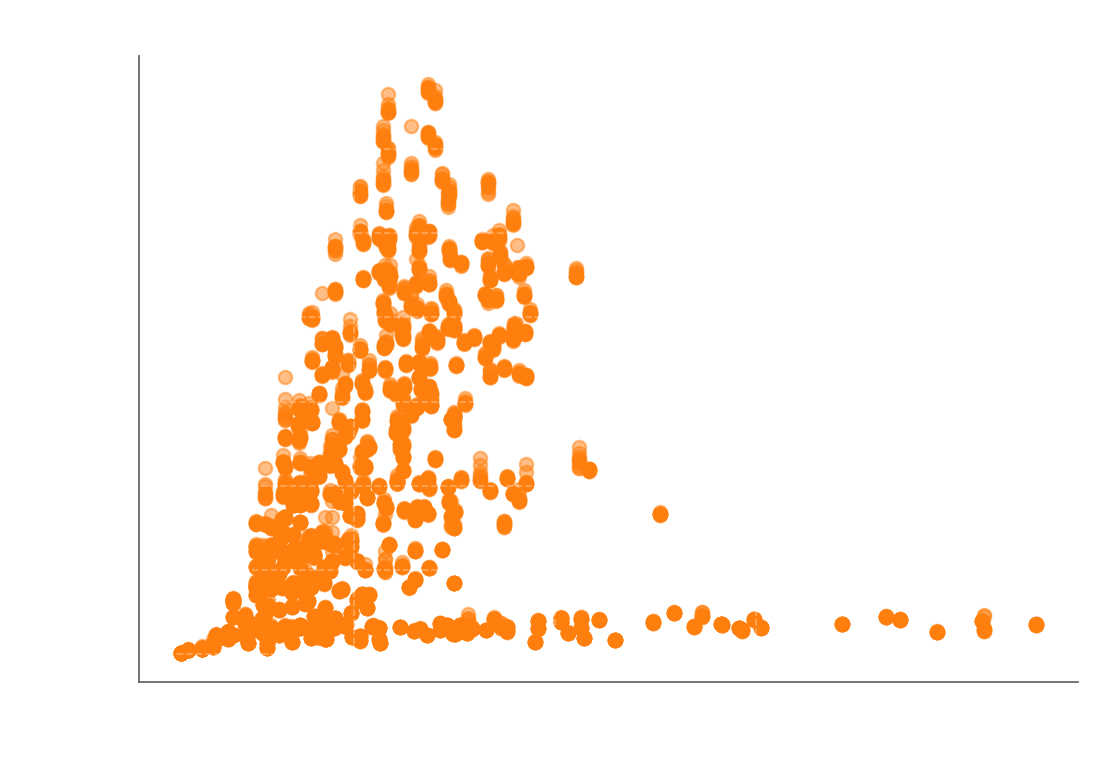

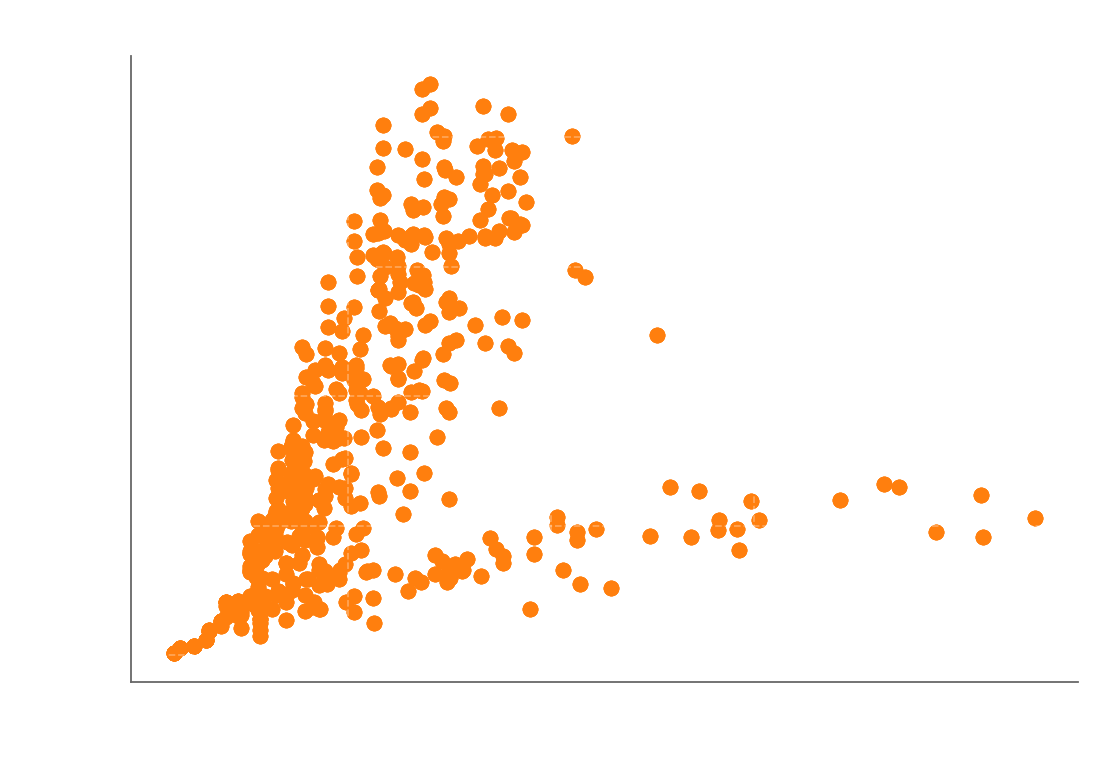

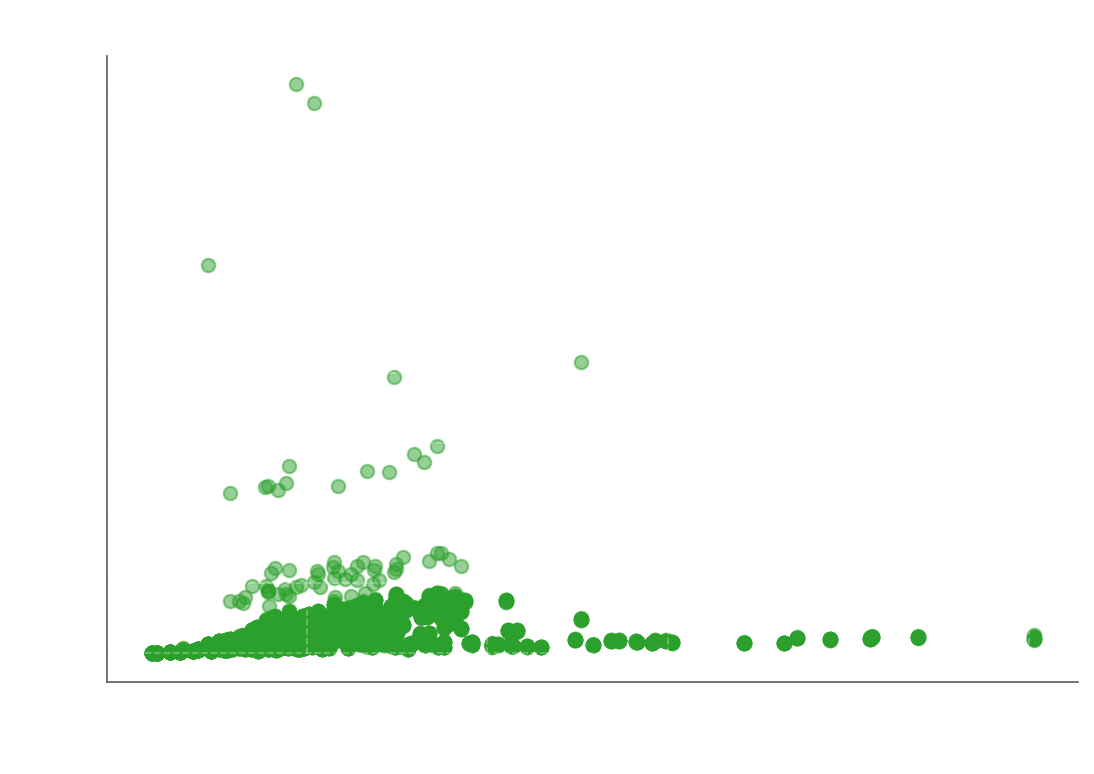

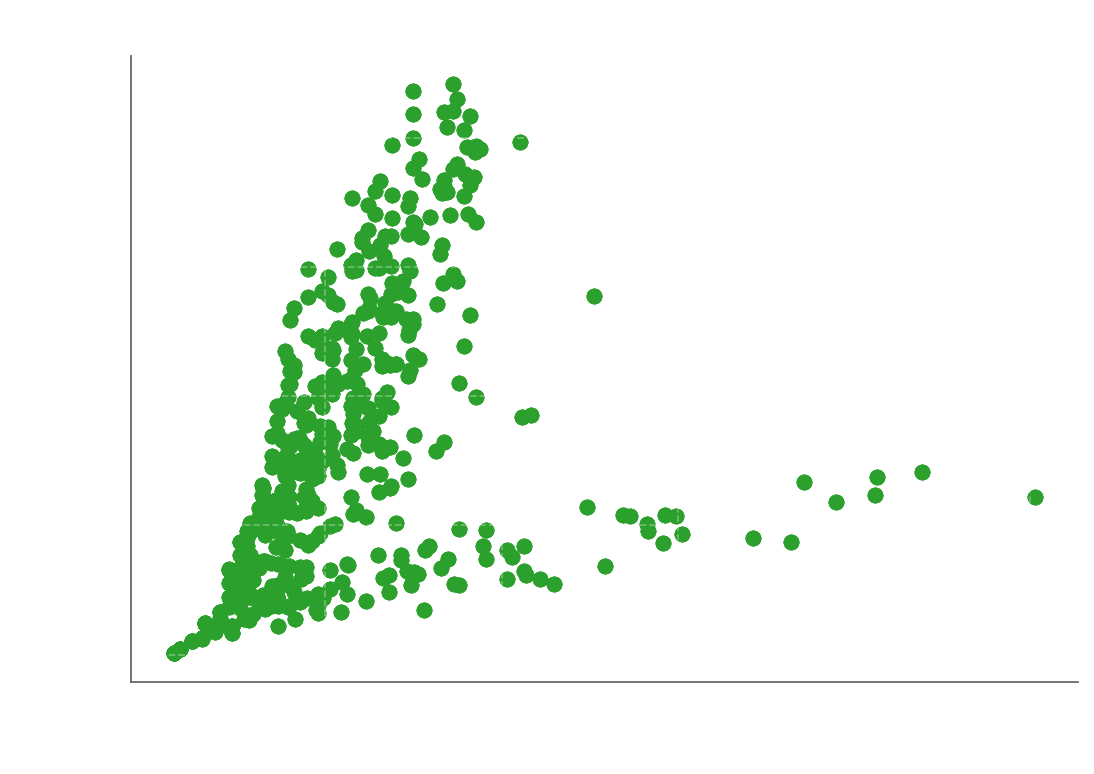

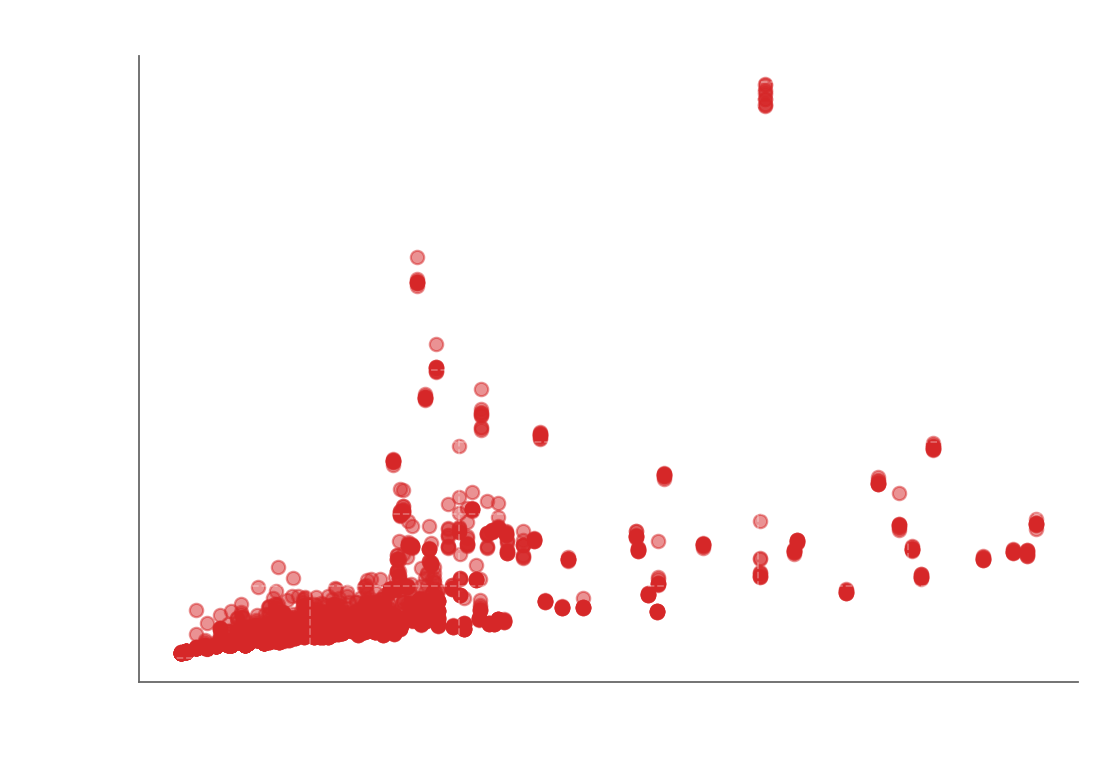

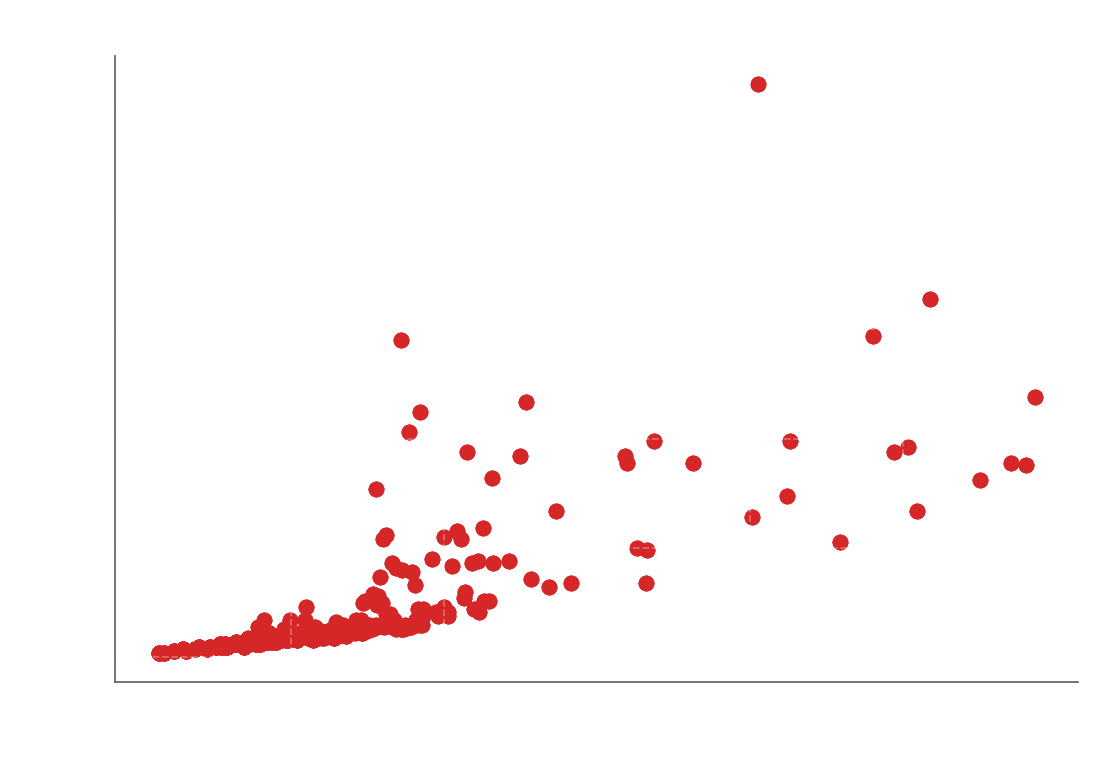

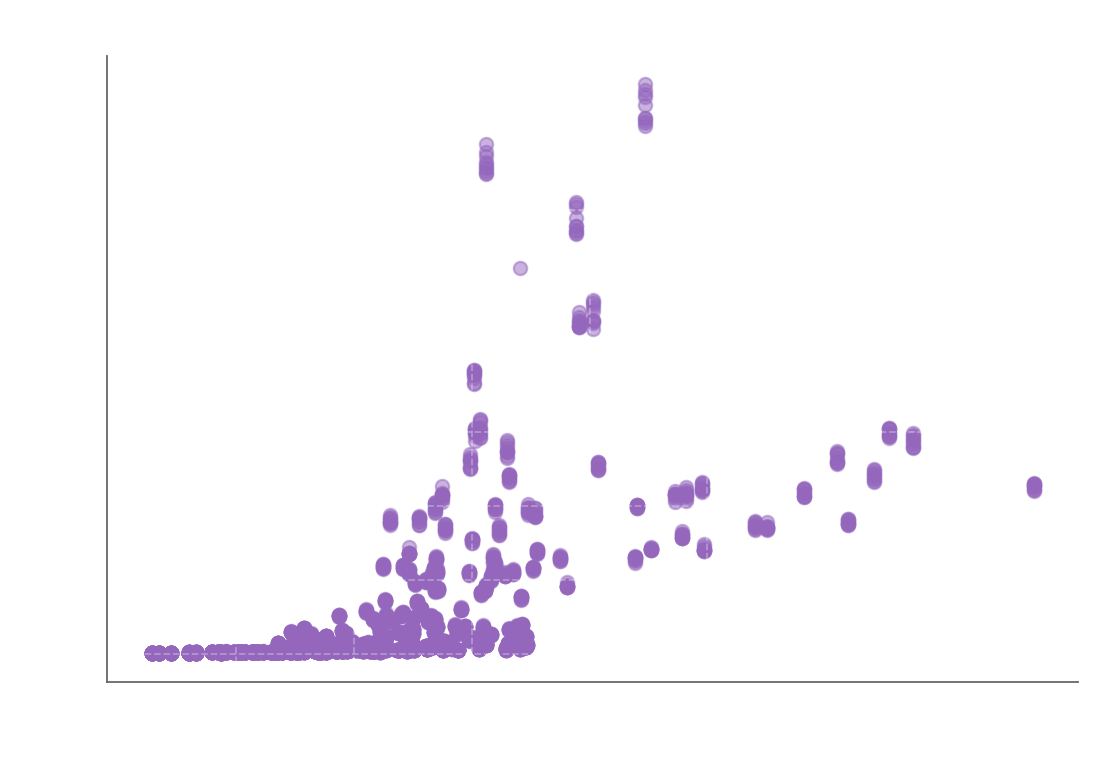

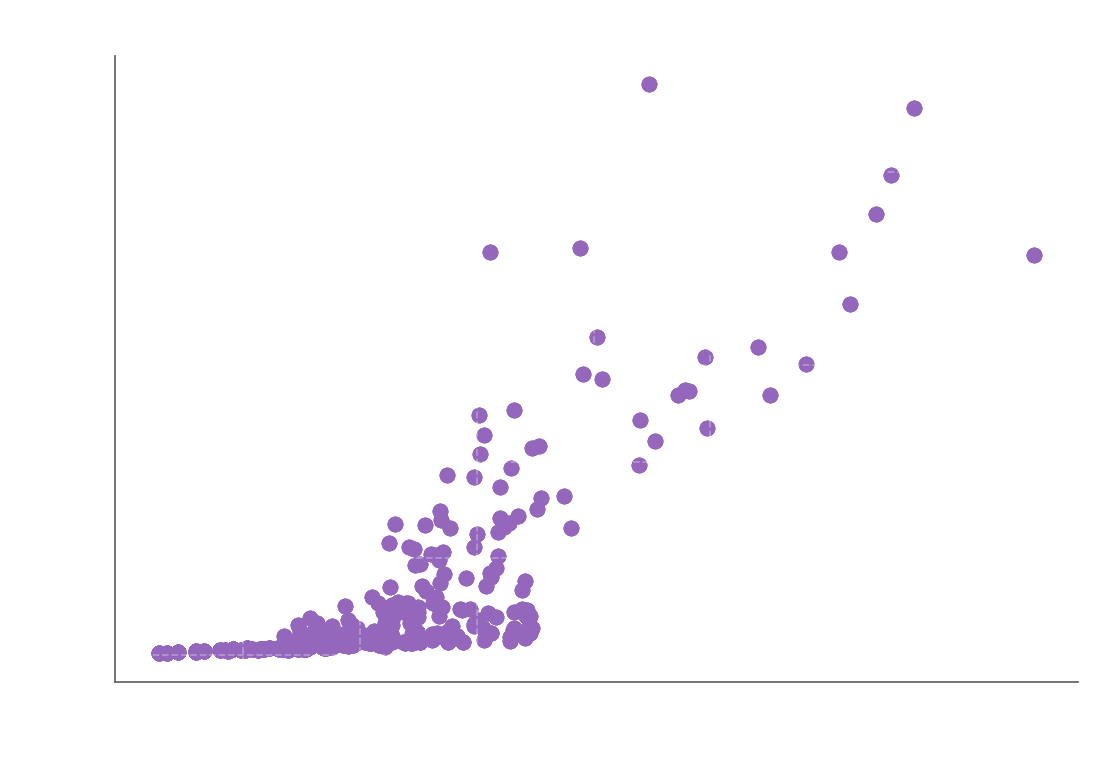

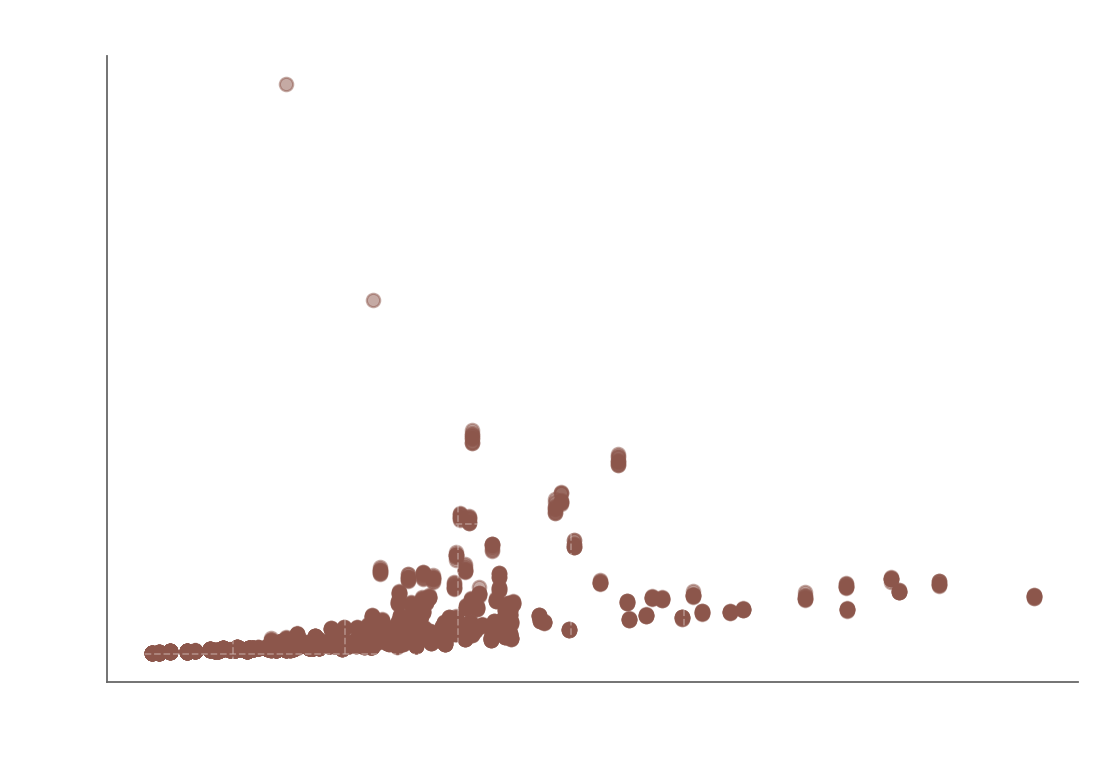

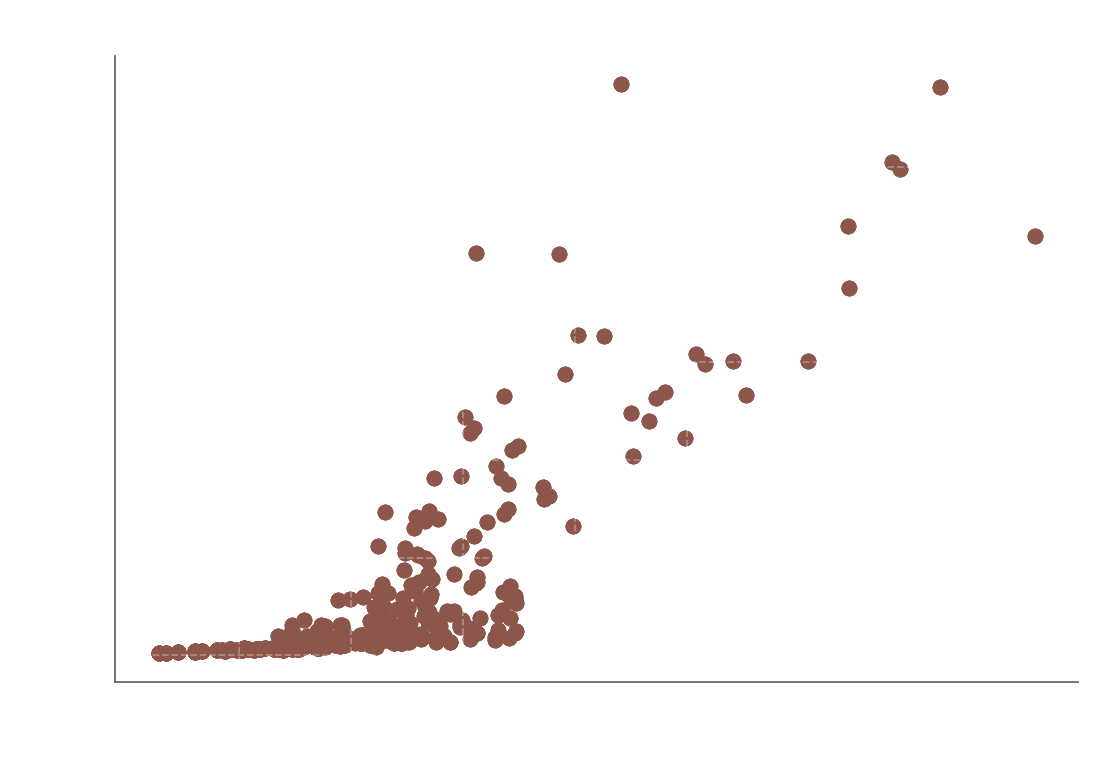

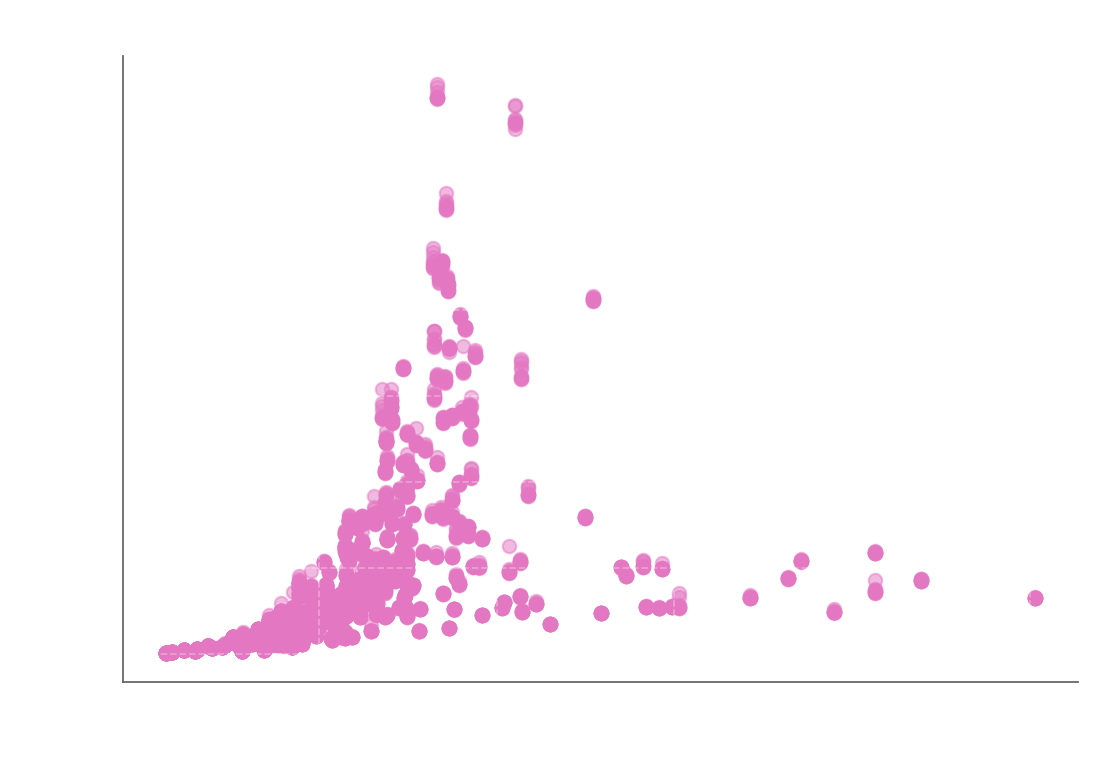

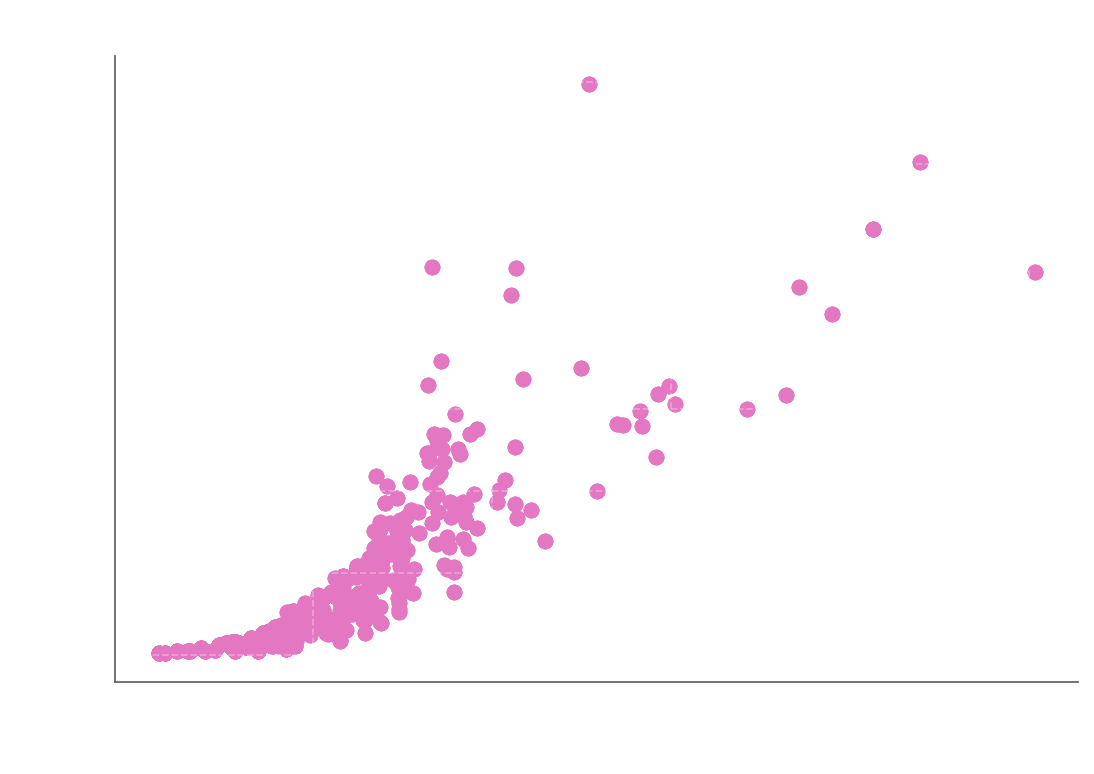

In [4]:
# Scatter plots: runtime vs. distance and visited nodes vs. distance for each algorithm
for alg in algorithms:
    sub = df[df["Algorithm"] == alg]
    plt.figure(figsize=(7,5))
    plt.scatter(sub["distance"], sub["runtime_s"], alpha=0.5, color=colors[alg])
    plt.xlabel("Path length (squares)")
    plt.ylabel("Runtime (s)")
    plt.title(f"Runtime vs. Distance — {alg}")
    savefig(out_dir / f"scatter_runtime_vs_distance_{alg}")
    
    plt.figure(figsize=(7,5))
    plt.scatter(sub["distance"], sub["visited"], alpha=0.5, color=colors[alg])
    plt.xlabel("Path length (squares)")
    plt.ylabel("Visited nodes")
    plt.title(f"Visited Nodes vs. Distance — {alg}")
    savefig(out_dir / f"scatter_visited_vs_distance_{alg}")

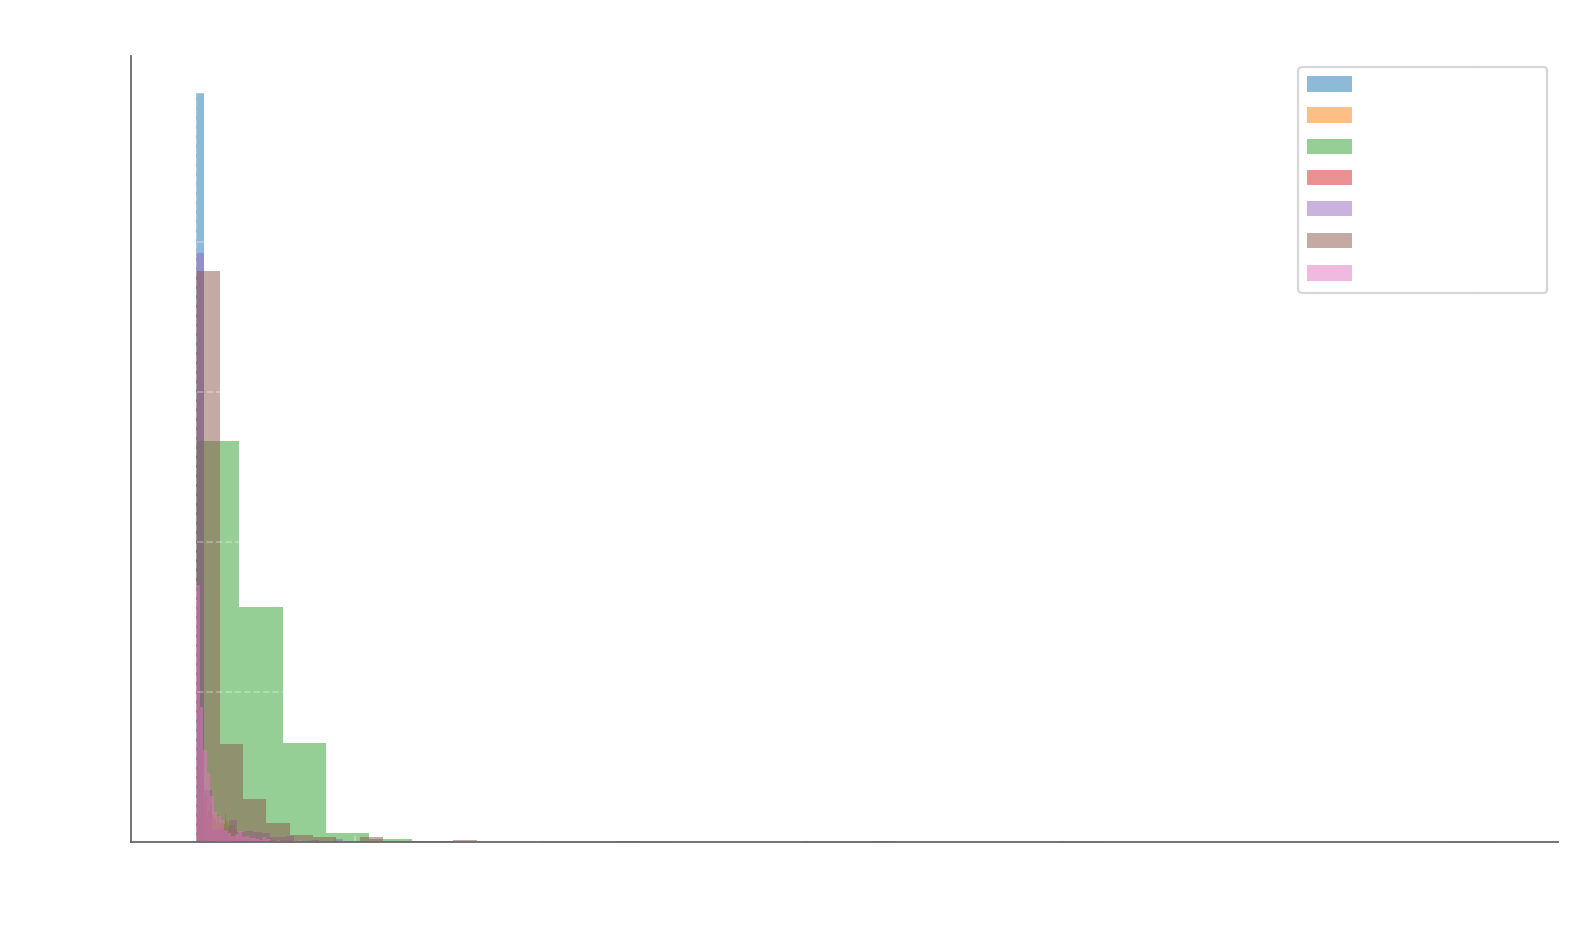

ValueError: supplied range of [1.4142135623730951, inf] is not finite

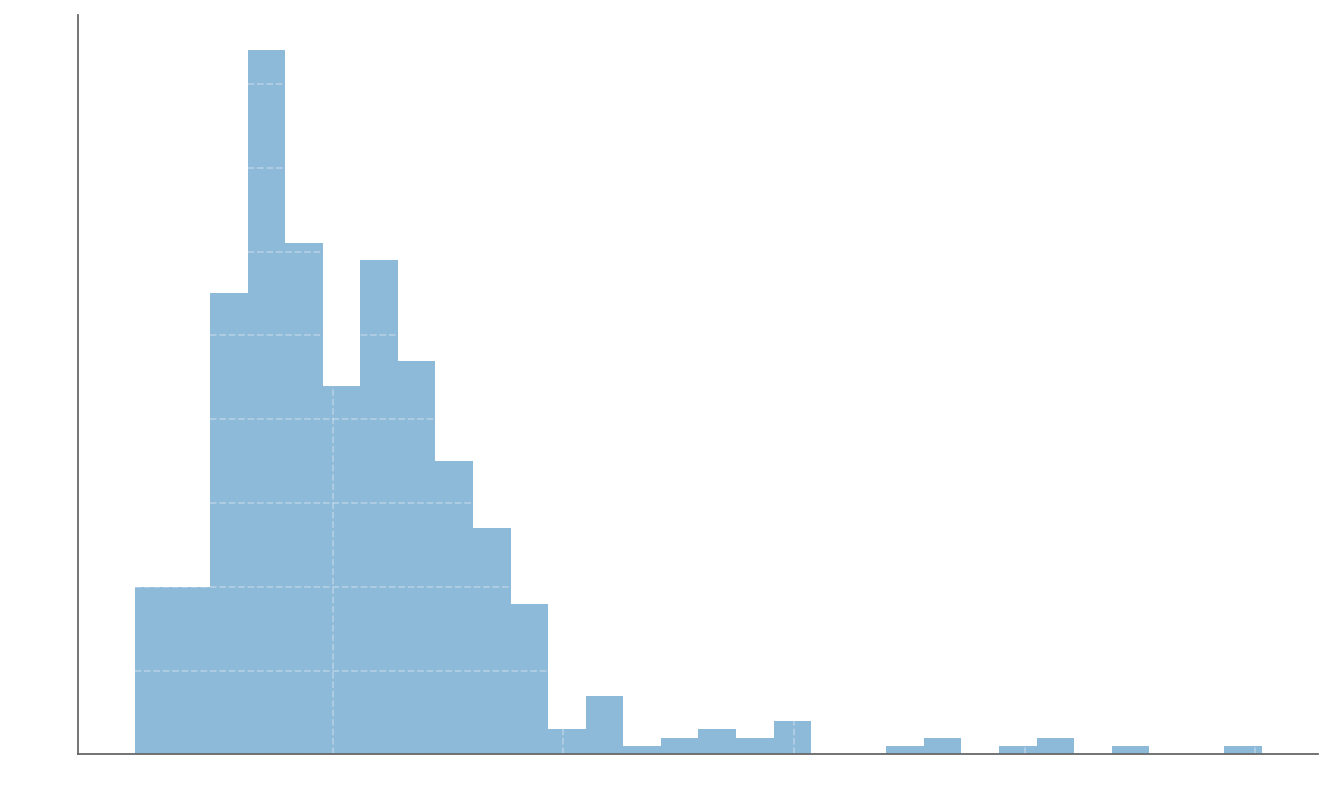

In [5]:
# Distribution plots (histograms) for runtime, distance, and visited nodes per algorithm
metrics = ["runtime_s", "distance", "visited"]
for metric in metrics:
    plt.figure(figsize=(10,6))
    for alg in algorithms:
        sub = df[df["Algorithm"] == alg]
        plt.hist(sub[metric], bins=30, alpha=0.5, label=alg, color=colors[alg])
    plt.xlabel(metric.replace('_s','').capitalize())
    plt.ylabel("Count")
    plt.title(f"Distribution of {metric.replace('_s','').capitalize()} by Algorithm")
    plt.legend()
    savefig(out_dir / f"hist_{metric}_by_algorithm")

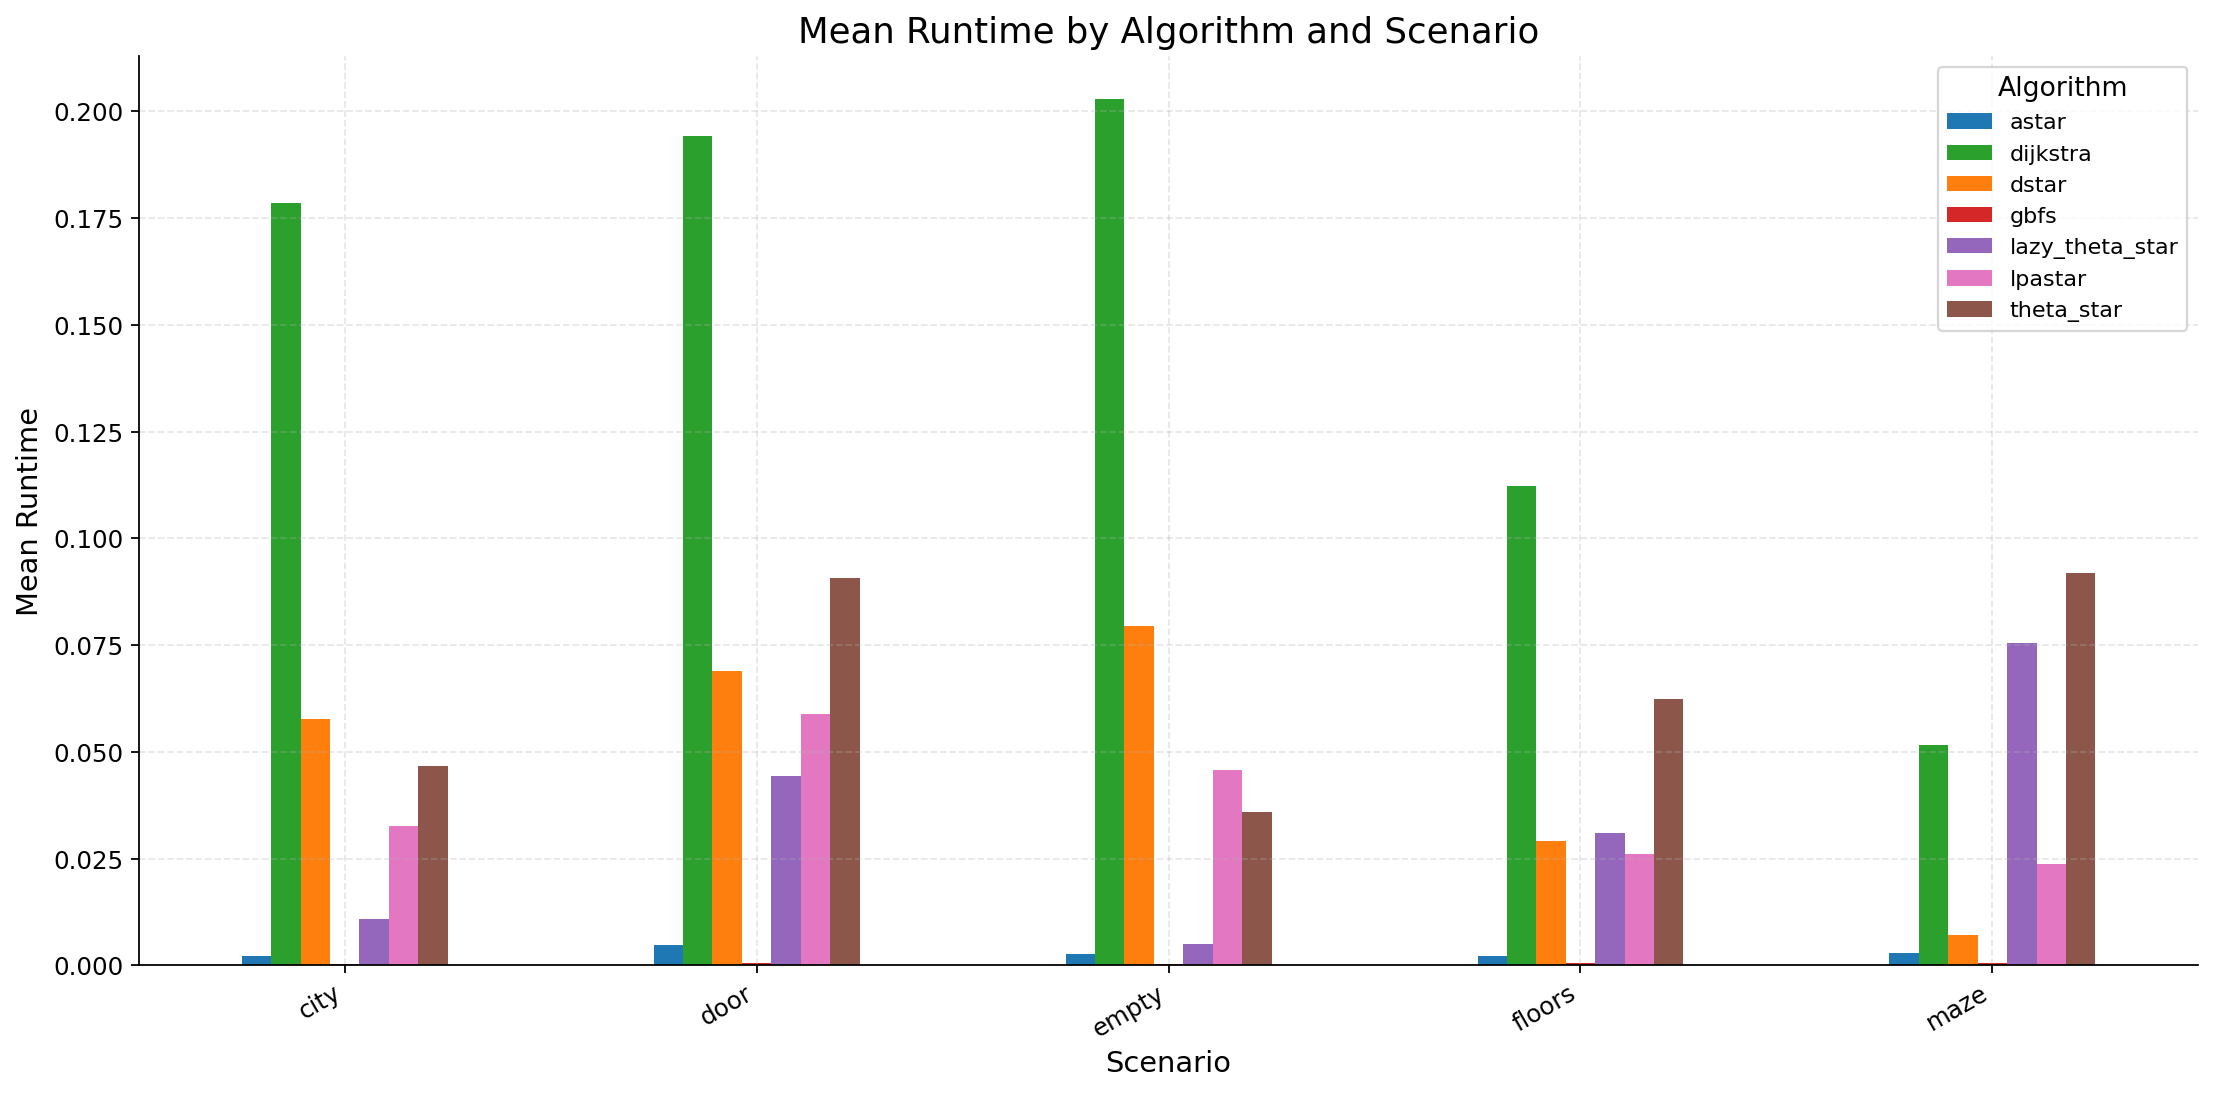

/home/teevik/Documents/Projects/python_motion_planning/.devenv/state/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/home/teevik/Documents/Projects/python_motion_planning/.devenv/state/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


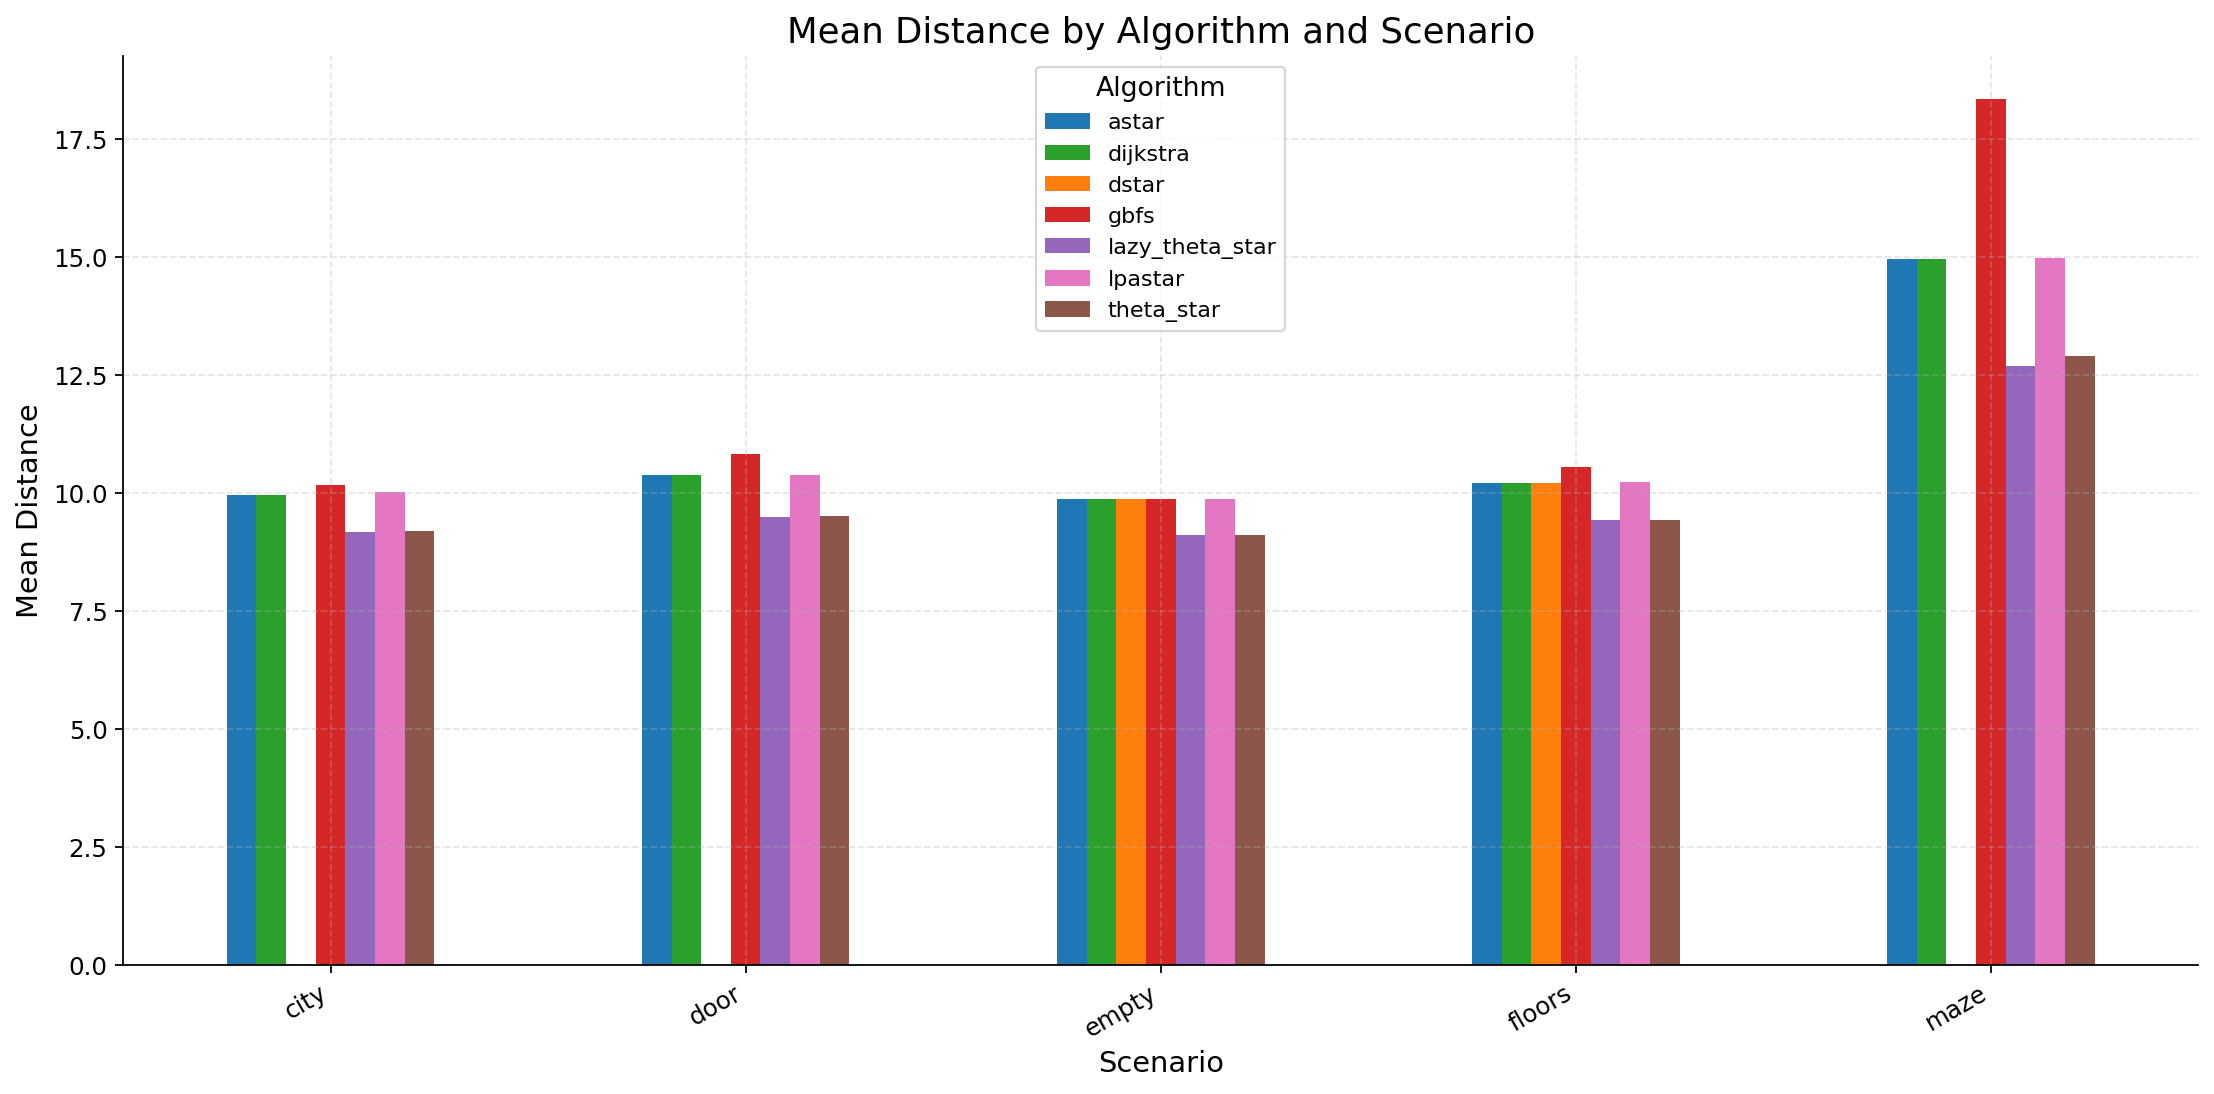

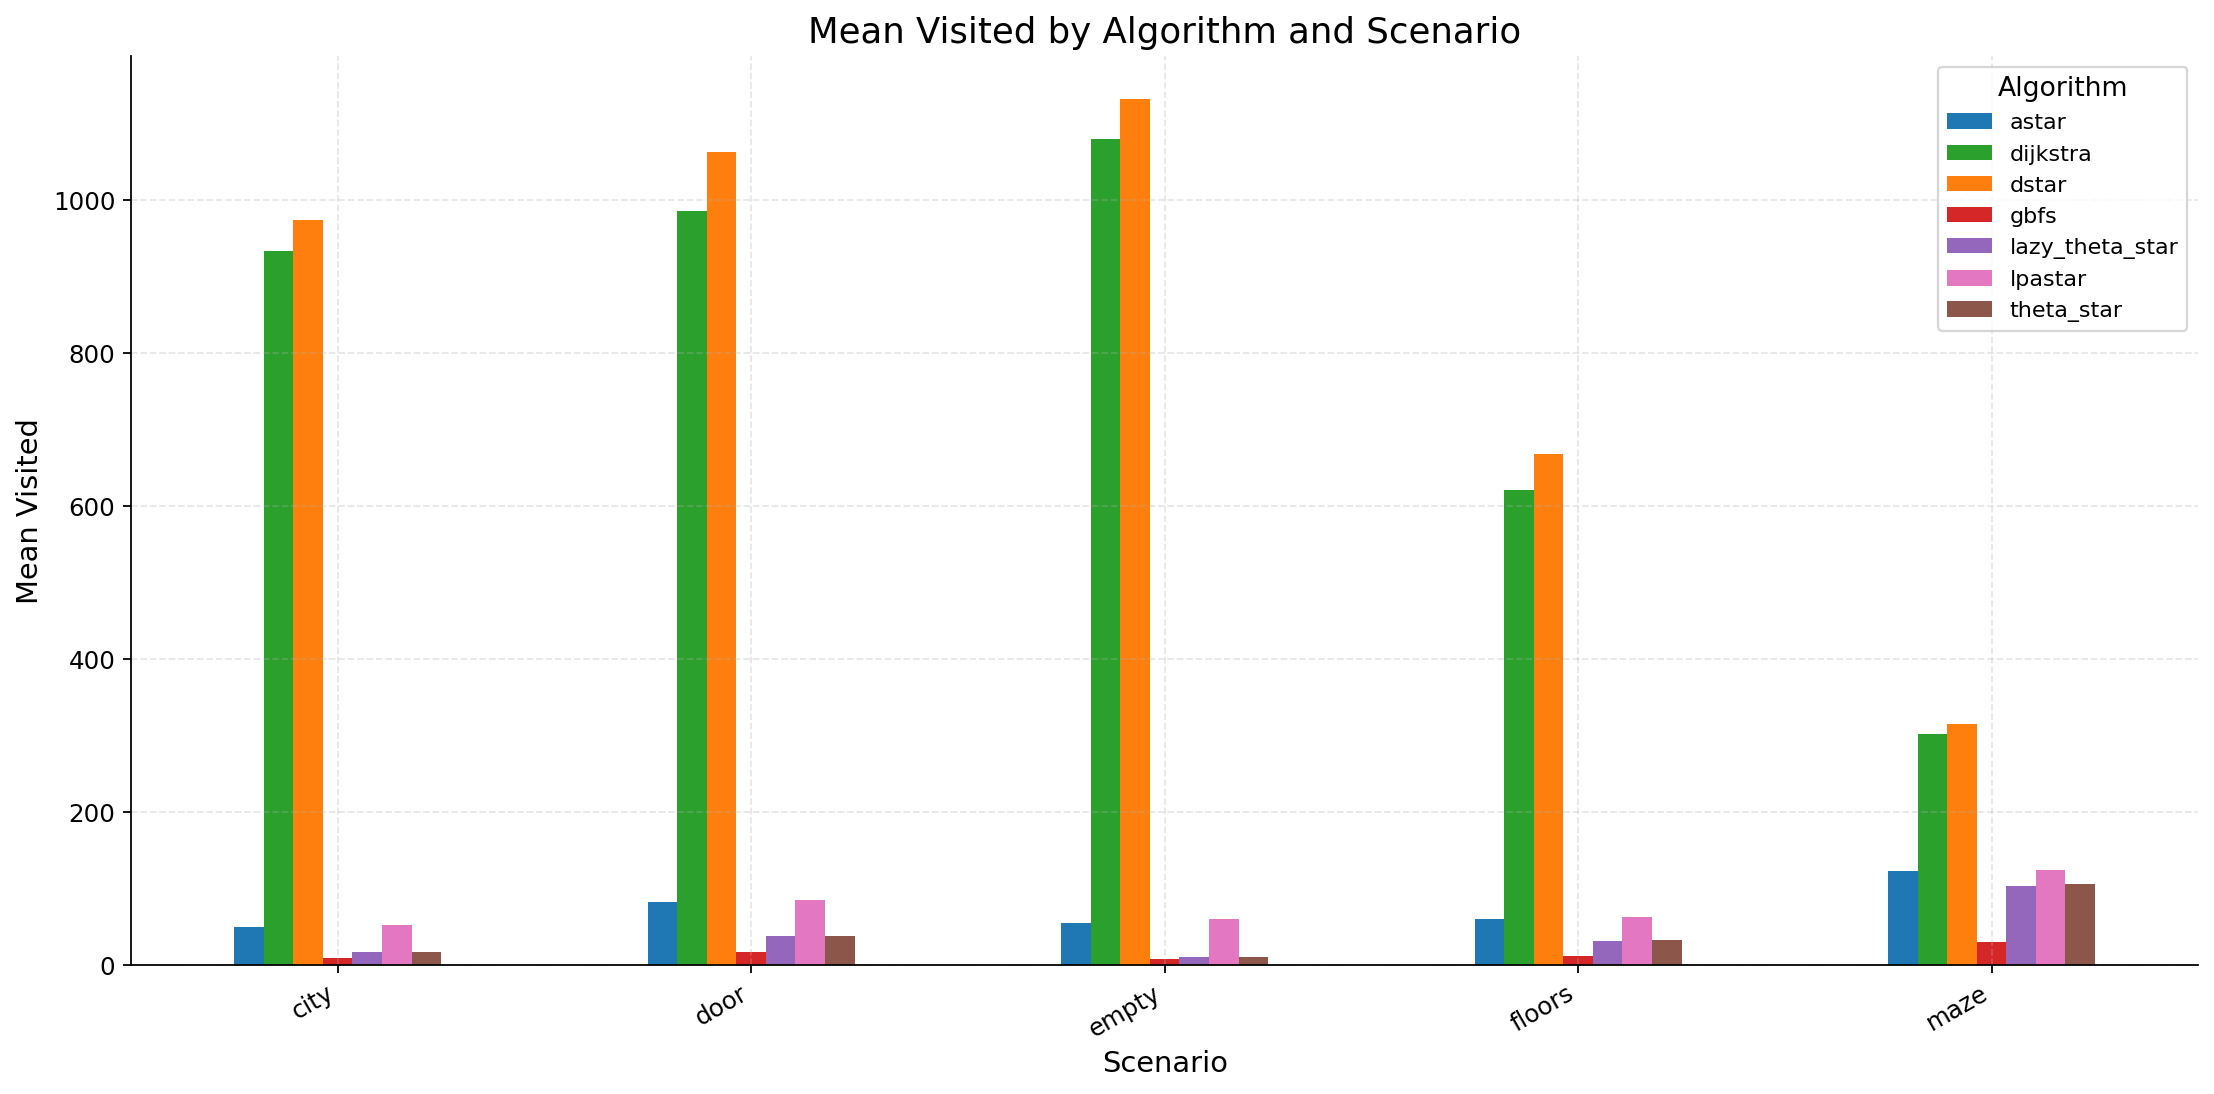

In [ ]:
# Grouped bar charts: Compare all algorithms across all scenarios in a single plot
metrics = ["runtime_s", "distance", "visited"]
for metric in metrics:
    means = df.groupby(["Scenario", "Algorithm"])[metric].mean().unstack()
    means.plot(kind="bar", figsize=(14,7), color=[colors[alg] for alg in means.columns])
    plt.ylabel(f"Mean {metric.replace('_s','').capitalize()}")
    plt.title(f"Mean {metric.replace('_s','').capitalize()} by Algorithm and Scenario")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Algorithm")
    savefig(out_dir / f"grouped_bar_{metric}_by_scenario")

In [ ]:
# Success rate plot (if applicable)
if "Success" in df.columns:
    success_rates = df.groupby(["Scenario", "Algorithm"])['Success'].mean().unstack()
    success_rates.plot(kind="bar", figsize=(14,7), color=[colors[alg] for alg in success_rates.columns])
    plt.ylabel("Success Rate")
    plt.title("Success Rate by Algorithm and Scenario")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Algorithm")
    savefig(out_dir / "success_rate_by_algorithm_and_scenario")

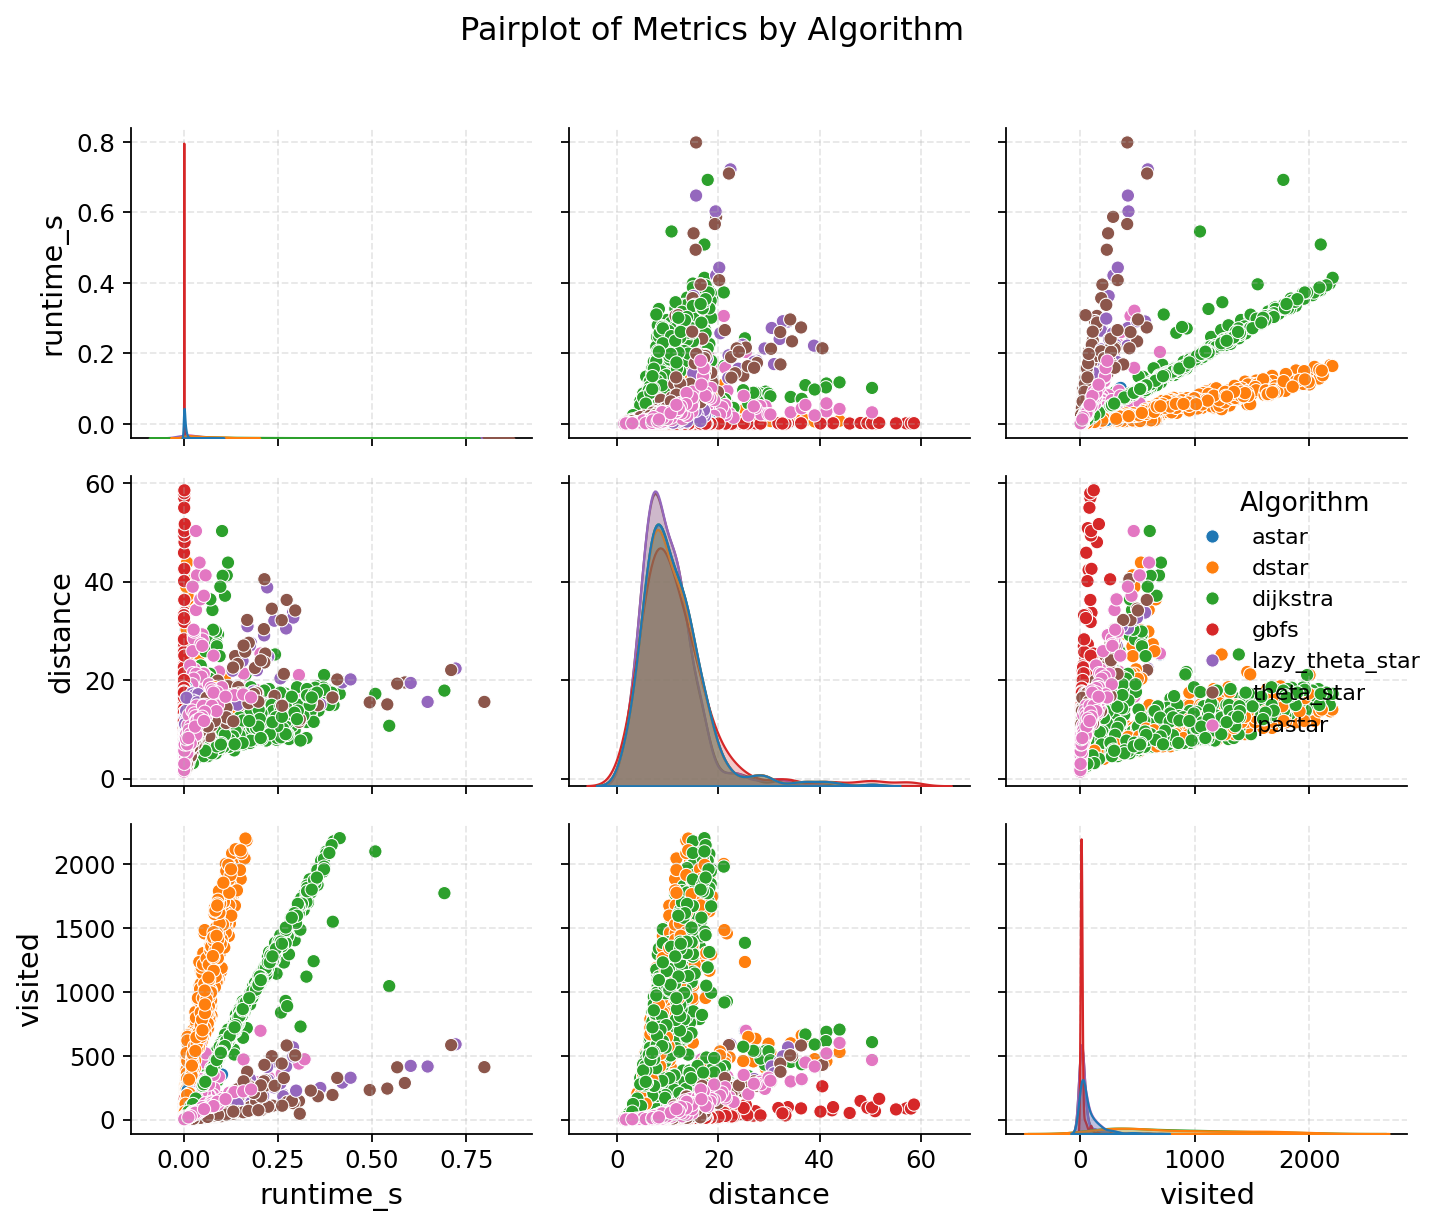

In [ ]:
# Pairplot/matrix plot for metric relationships using seaborn
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("bright")
g = sns.pairplot(df, vars=["runtime_s", "distance", "visited"], hue="Algorithm", palette=colors)
g.fig.suptitle("Pairplot of Metrics by Algorithm", y=1.02, color='white')
for ax in g.axes.flat:
    ax.set_facecolor('#1a1a1a')
plt.tight_layout()
plt.show()

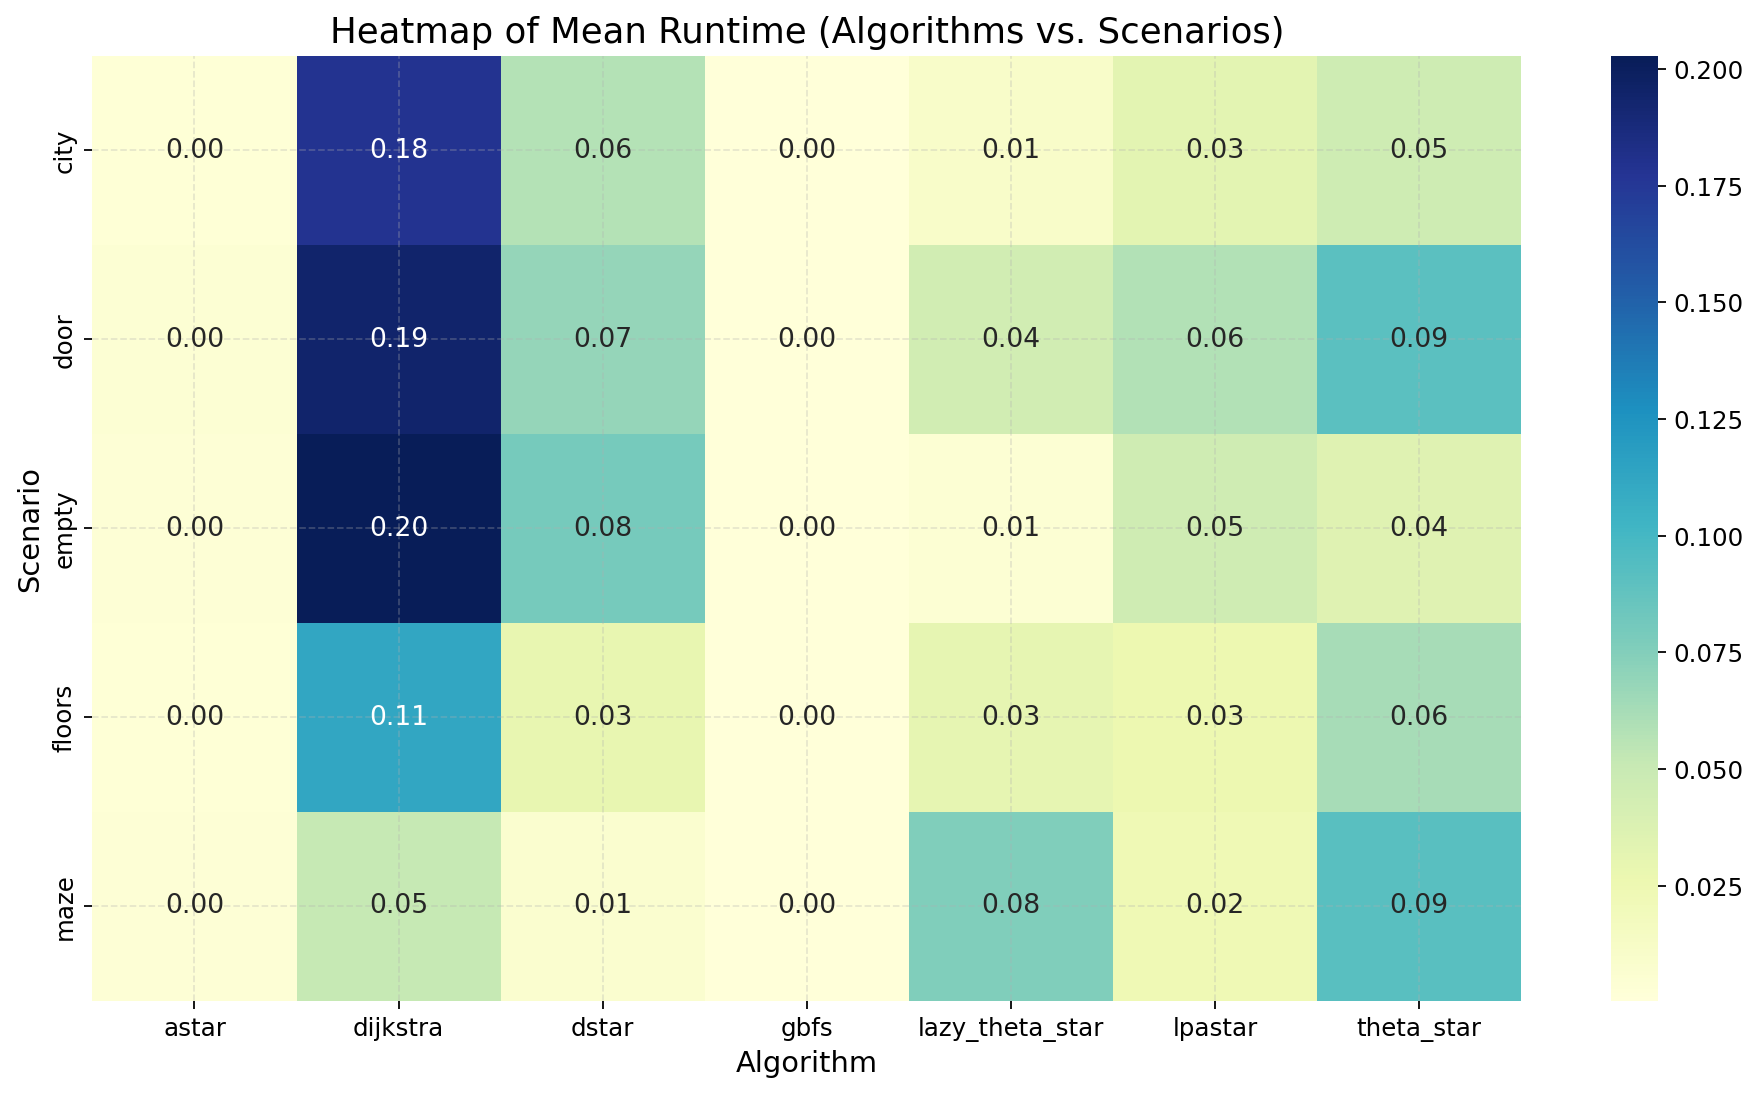

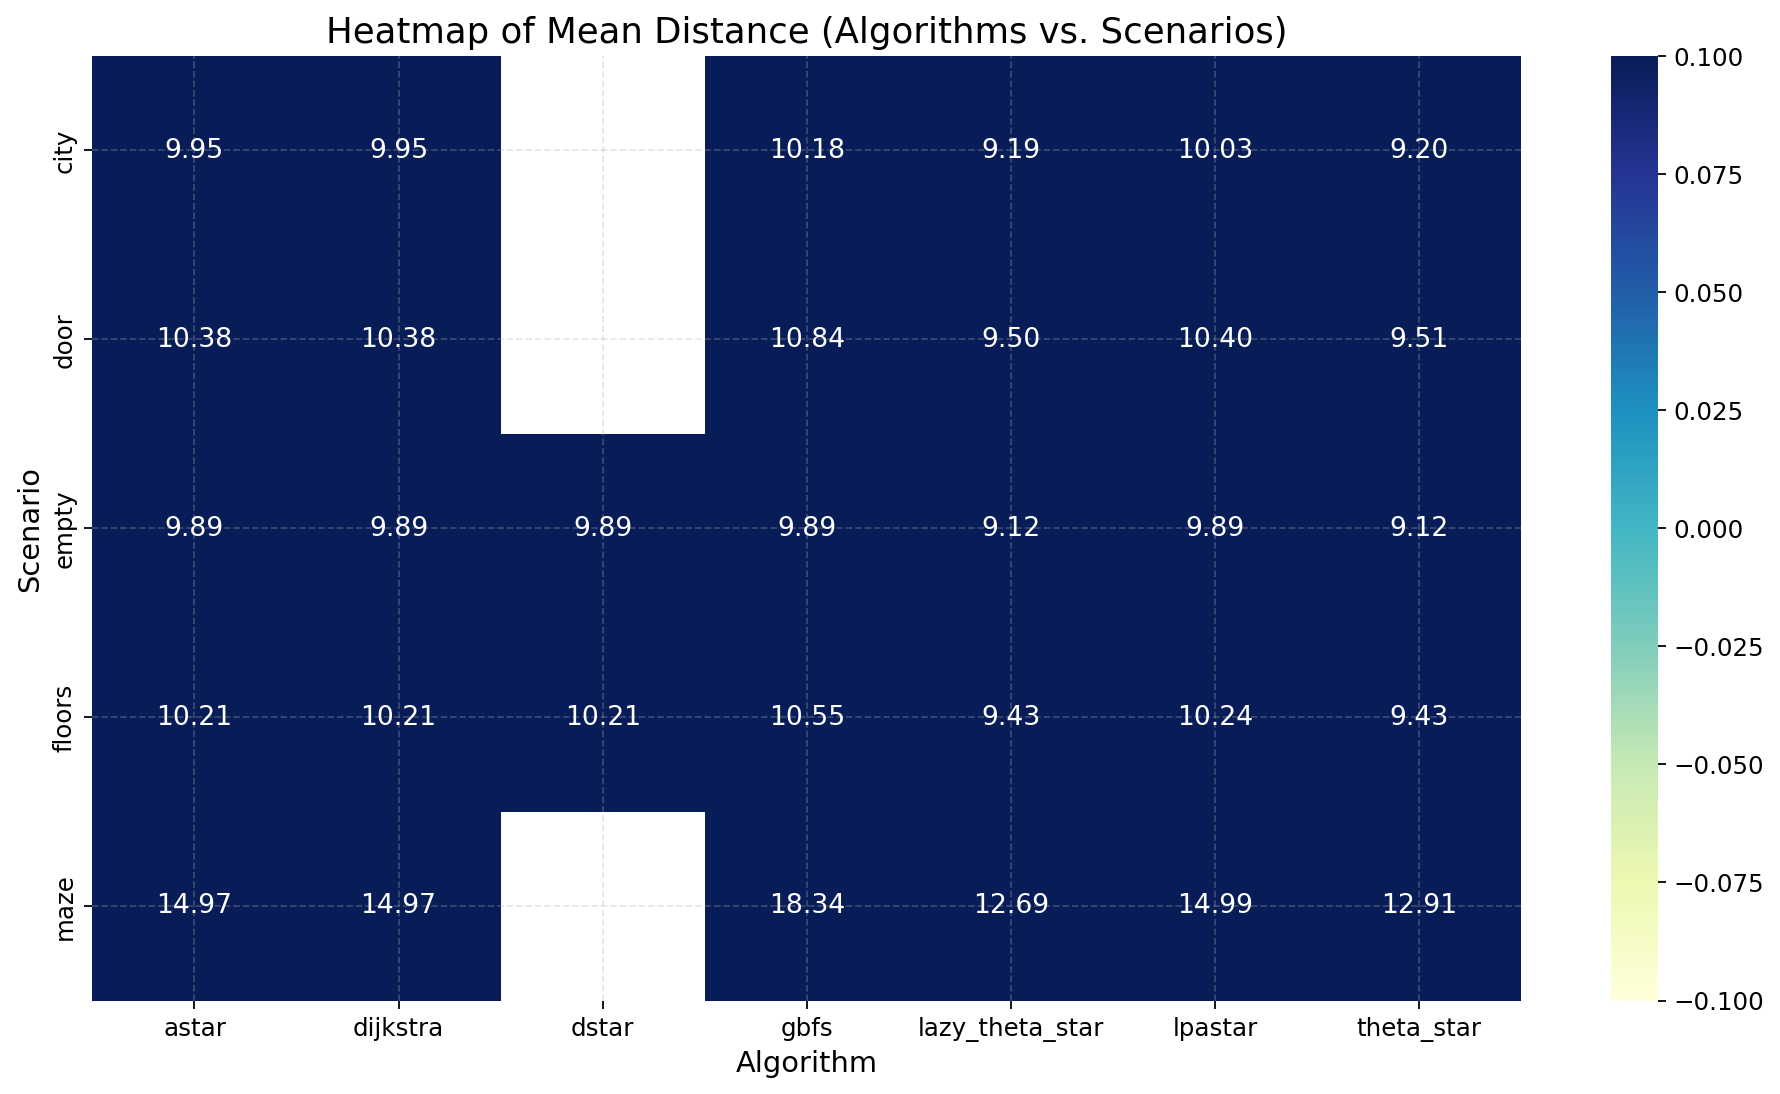

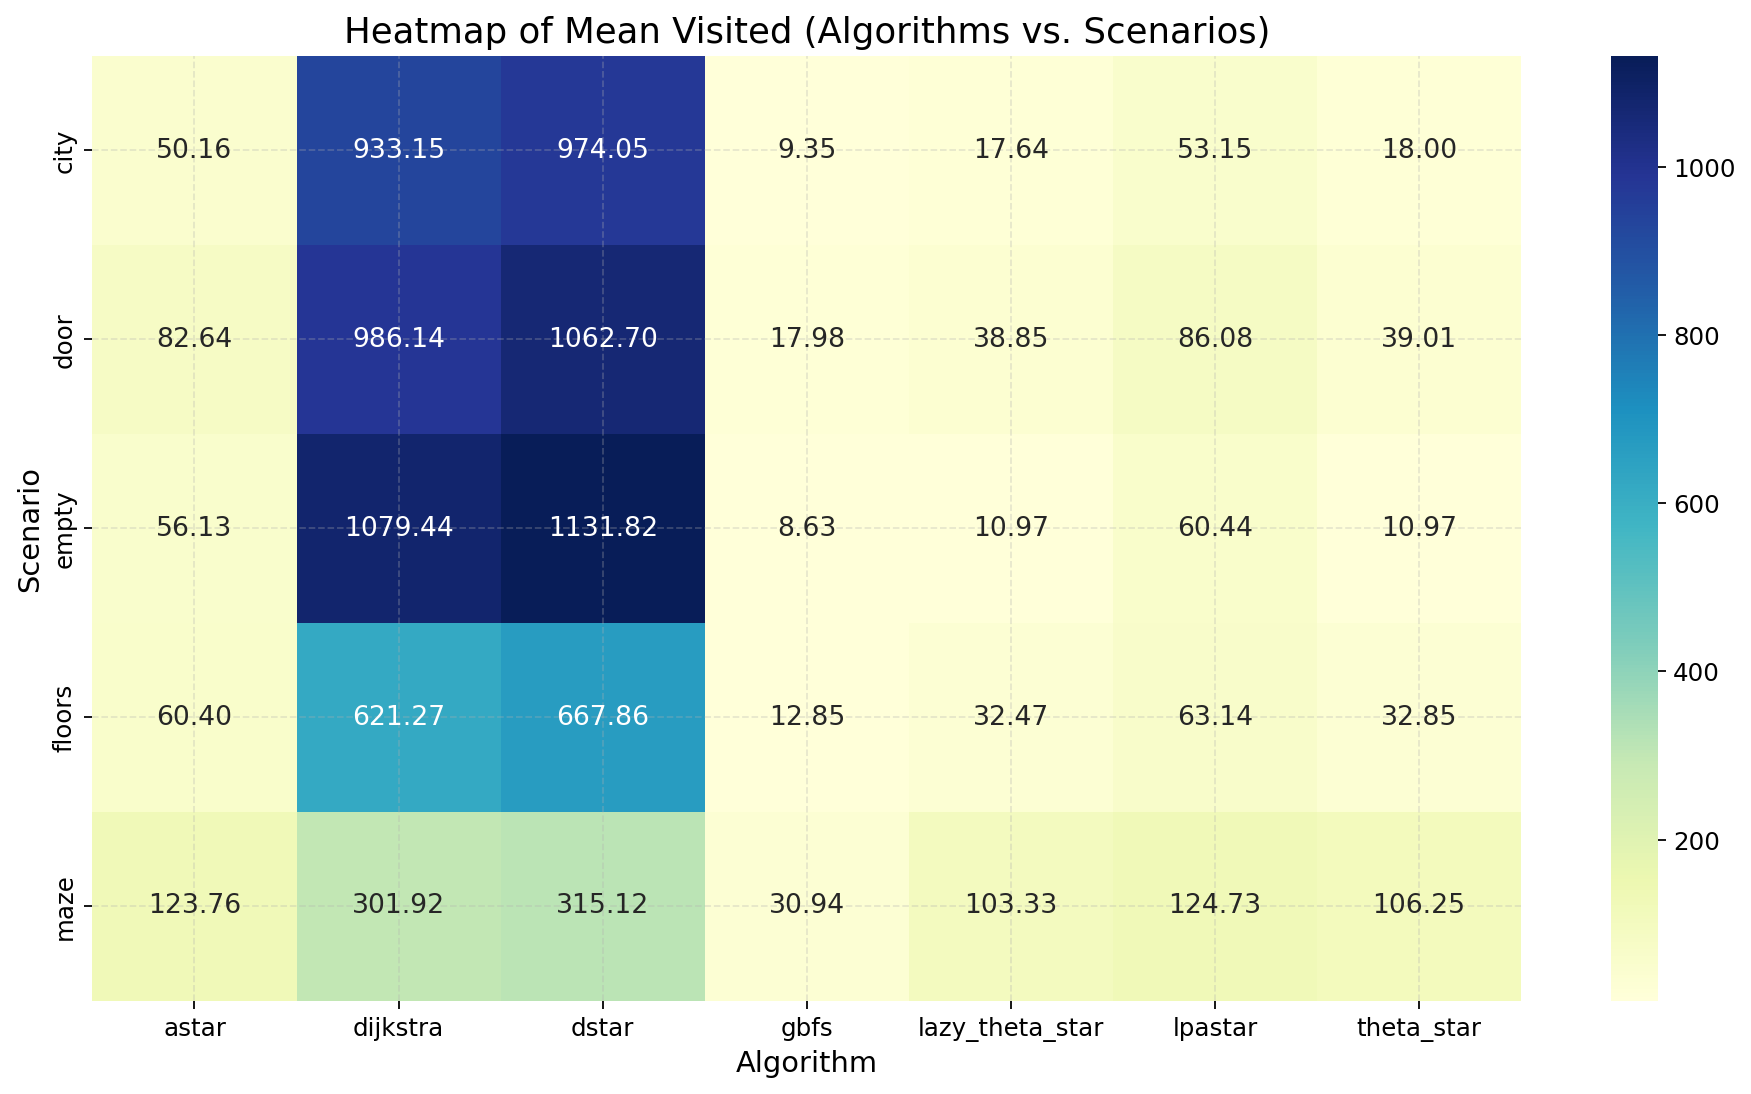

In [ ]:
# Heatmap of mean metrics (algorithms vs. scenarios)
metrics = ["runtime_s", "distance", "visited"]
import seaborn as sns
for metric in metrics:
    pivot = df.groupby(["Scenario", "Algorithm"])[metric].mean().unstack()
    plt.figure(figsize=(12,7))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"Heatmap of Mean {metric.replace('_s','').capitalize()} (Algorithms vs. Scenarios)")
    plt.ylabel("Scenario")
    plt.xlabel("Algorithm")
    savefig(out_dir / f"heatmap_{metric}_alg_vs_scen")